In [1]:
import os
import sys
sys.path.append("../")

import math
import random
from scipy import special
import numpy as np
import torch
# import tensorflow as tf
import matplotlib.pyplot as plt
import time
import logging
from pynverse import inversefunc
from utilities.compare_performance import compare_performance
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from functools import partial

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import numpy as np
from sympy import *
import sympy as sp
#import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import quad

mu = 0.05
dim = 1 

def v0(x):
    return x**2*(3-2*x)

def w(x,mu):
    return exp(-v0(x)/3/mu)

c=[quad(w,0,1,args=(mu))[0]]

def w0(x,k,mu):
    return exp(-v0(x)/3/mu)*cos(k*np.pi*x)

nb_sums=14;    

for k in range(1,nb_sums):
    c.append(2*quad(w0,0,1,args=(k,mu))[0])
    
def exact_example(t, x, T):
    xi = (1+sum(x))/2
    if t==T: 
        return 4*xi*(1-xi)
    else:
        sum1 = 0  
        for n in range(1,nb_sums):
            sum1 += c[n]*n*np.exp(-n**2*np.pi**2*mu*dim*(T-t))*np.sin(n*np.pi*xi)
        sum2 = 0
        for n in range(1,nb_sums):
            sum2 += c[n]*np.exp(-n**2*np.pi**2*mu*dim*(T-t))*np.cos(n*np.pi*xi)
        return 2*np.pi*mu*sum1/(c[0]+sum2)


In [3]:
exact_example(0, [0.3], 0.05)

0.936607663317853

In [4]:
nu=mu*4

def f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) 
  
def dgm_f_example(y, coordinate=0):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return -2*y[0]*y[1:(dim+1)].sum(dim=0) + nu*y[(dim+1):(2*dim+1)].sum(dim=0)

def phi_example(x, coordinate=0):
    return 4*(1+x.sum(axis=0))/2*(1-(1+x.sum(axis=0))/2)

# def exact_example(t, x, T):
#    xi = T-t + x.sum(axis=0)
#    return np.sin(np.pi*(1+xi)/2)

def boundary_fun(x, coordinate=0):
    return torch.tensor(np.zeros(x.size()[1]), device=device).to(torch.float32)

t_lo, x_lo, x_hi = 0., -1, 1
    
x_mid = (x_lo + x_hi) / 2
grid = np.linspace(x_lo, x_hi, 100)

In [5]:
# Conditional probability to survive
# Set boundary of DB and BSDE methods
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-1,
    upper_bound=1,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    # print(ans.transpose(0, -1).prod(dim=0))
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=x_lo, upper_bound=x_hi):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

## dim = 1

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 0.9880046844482422 seconds.
Patch  0: epoch    0 with loss 1.36E+00


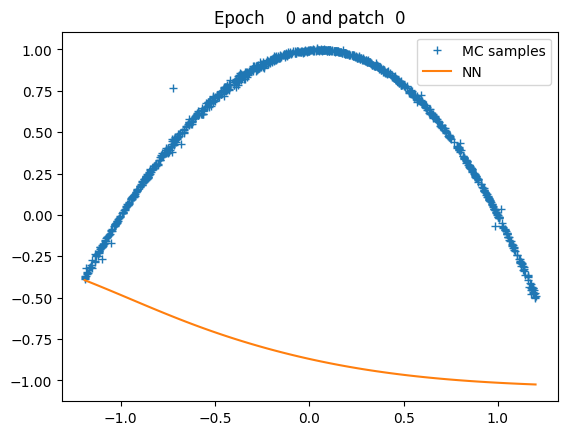

Patch  0: epoch  500 with loss 2.18E-04


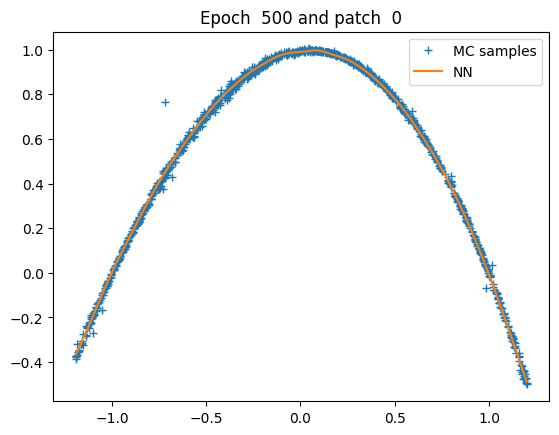

Patch  0: epoch 1000 with loss 2.17E-04


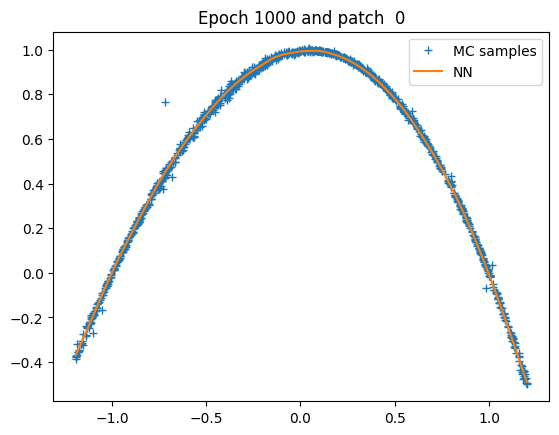

Patch  0: epoch 1500 with loss 2.17E-04


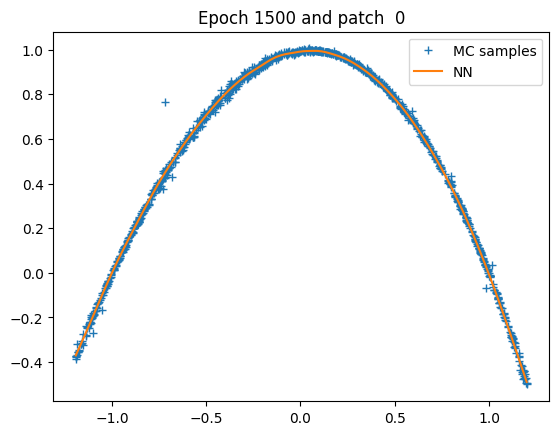

Patch  0: epoch 2000 with loss 2.16E-04


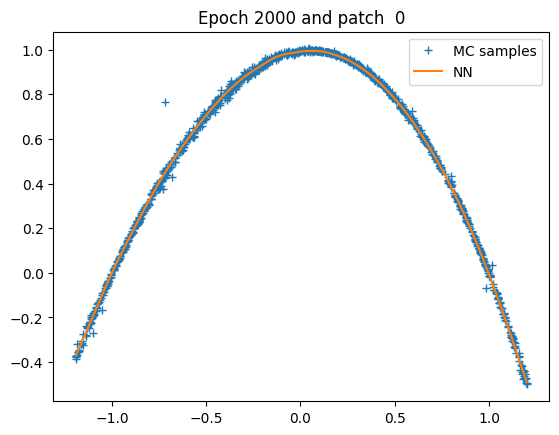

Patch  0: epoch 2499 with loss 2.16E-04


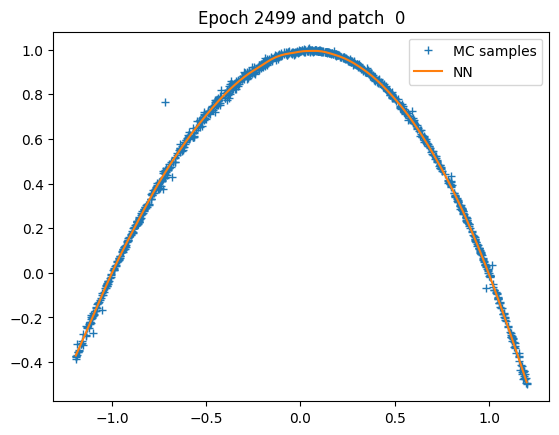

Patch 0: training of u with 2500 epochs take 18.339614152908325 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 1: generation of u samples take 4.78051495552063 seconds.
Patch  1: epoch    0 with loss 2.23E+00


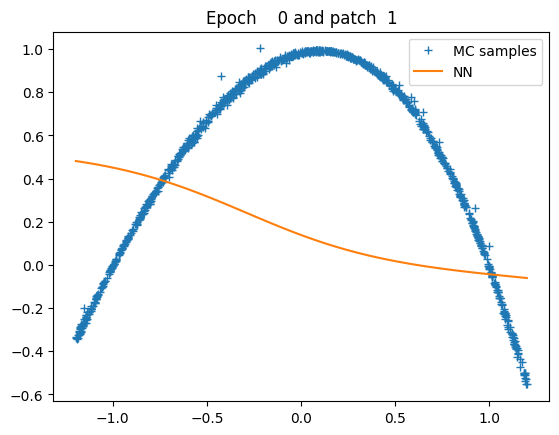

Patch  1: epoch  500 with loss 1.32E-04


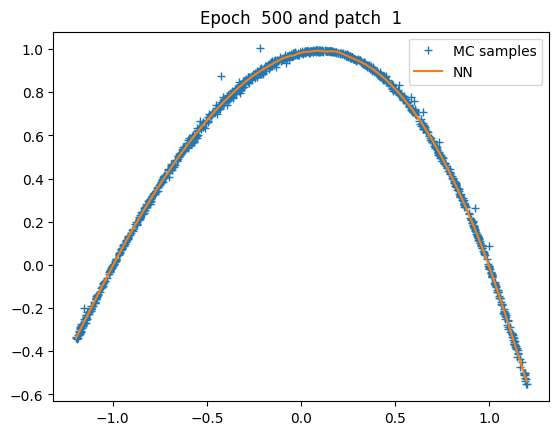

Patch  1: epoch 1000 with loss 1.31E-04


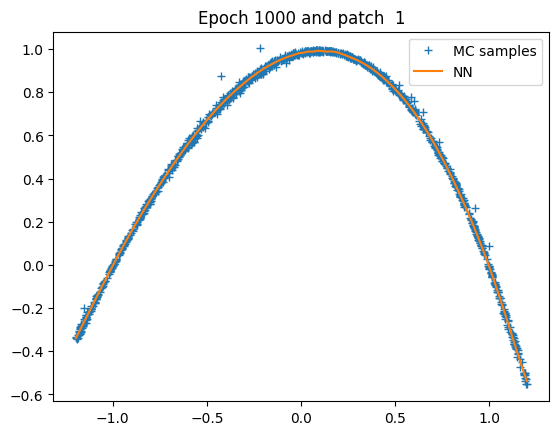

Patch  1: epoch 1500 with loss 1.31E-04


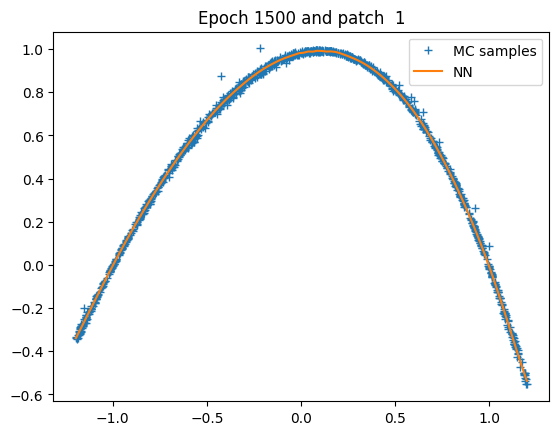

Patch  1: epoch 2000 with loss 1.31E-04


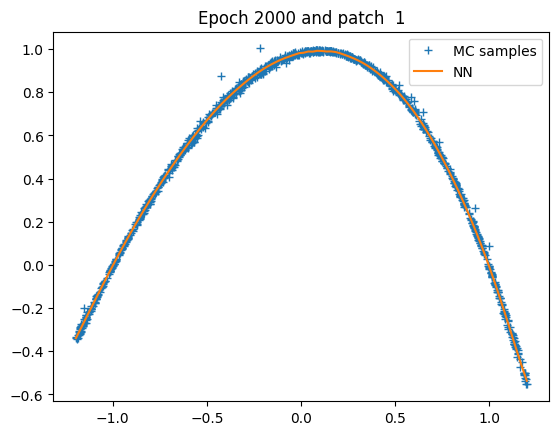

Patch  1: epoch 2499 with loss 1.31E-04


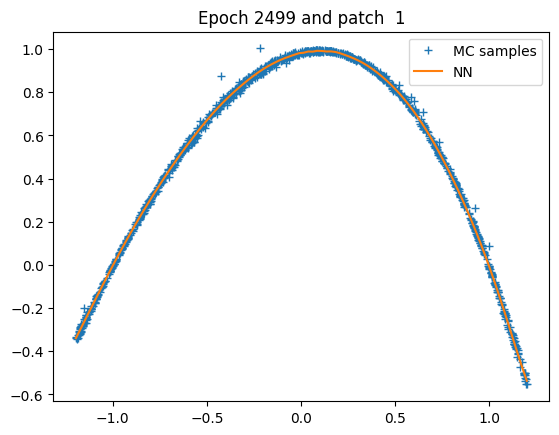

Patch 1: training of u with 2500 epochs take 19.95402765274048 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 2: generation of u samples take 3.798007011413574 seconds.
Patch  2: epoch    0 with loss 1.63E+00


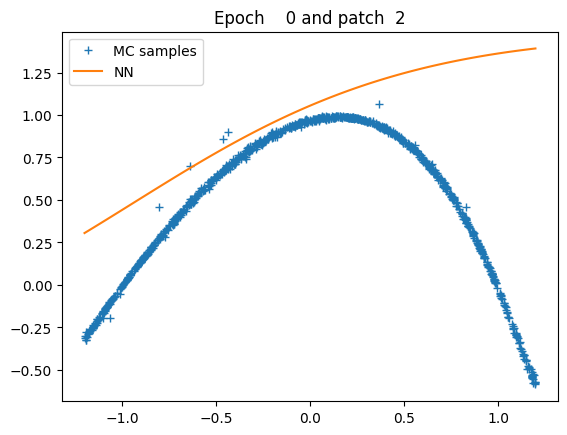

Patch  2: epoch  500 with loss 2.53E-04


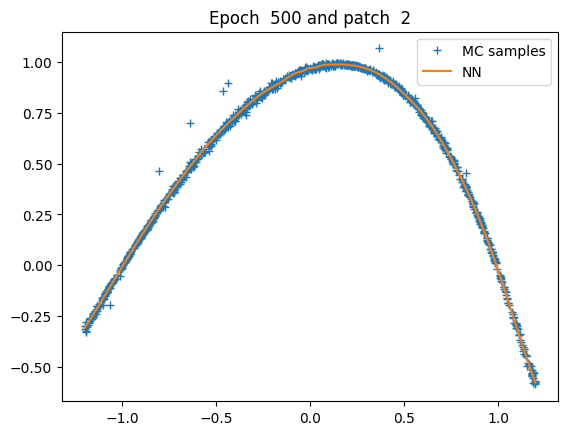

Patch  2: epoch 1000 with loss 2.51E-04


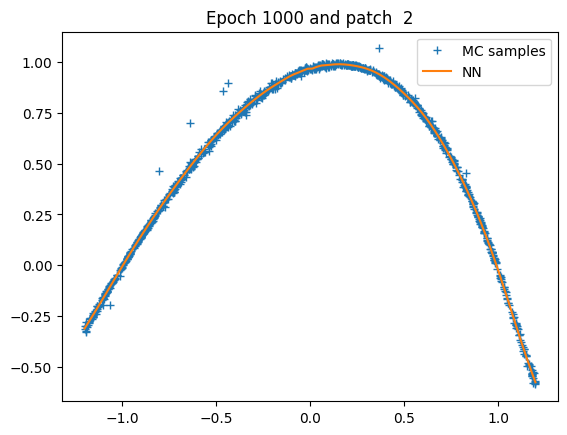

Patch  2: epoch 1500 with loss 2.51E-04


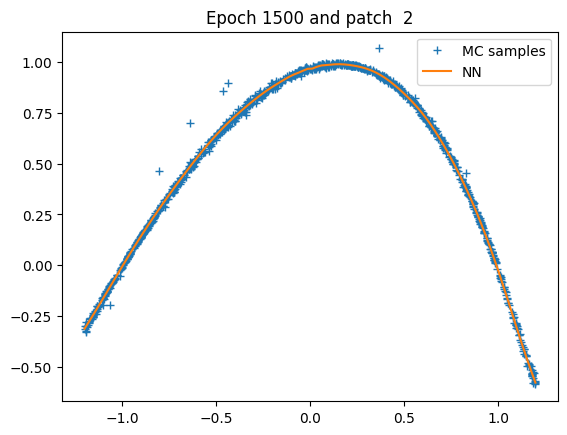

Patch  2: epoch 2000 with loss 2.51E-04


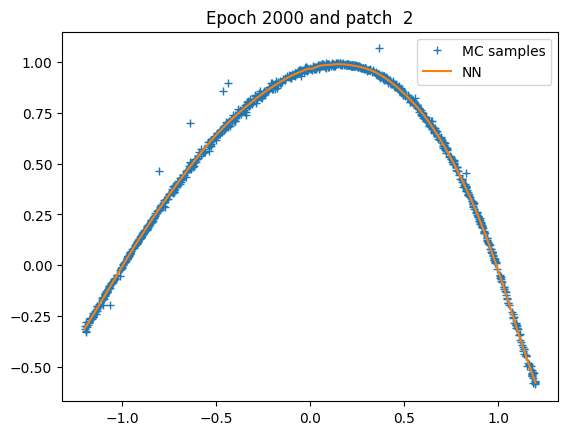

Patch  2: epoch 2499 with loss 2.51E-04


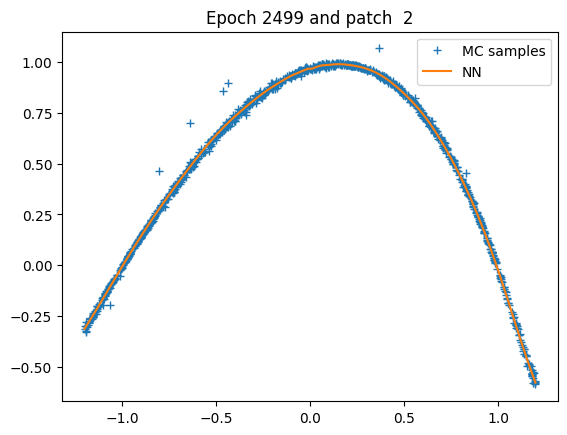

Patch 2: training of u with 2500 epochs take 19.95352864265442 seconds.


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 3: generation of u samples take 3.9251956939697266 seconds.
Patch  3: epoch    0 with loss 3.80E+00


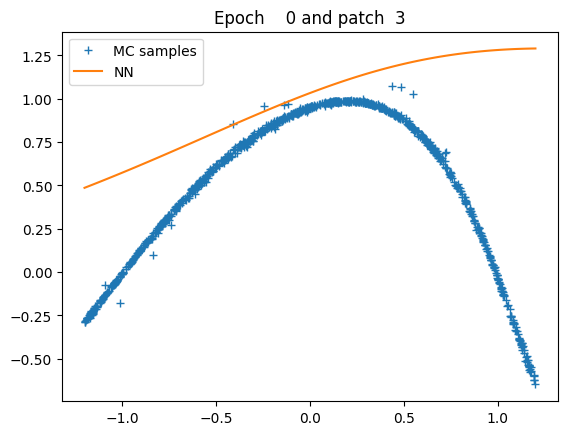

Patch  3: epoch  500 with loss 2.74E-04


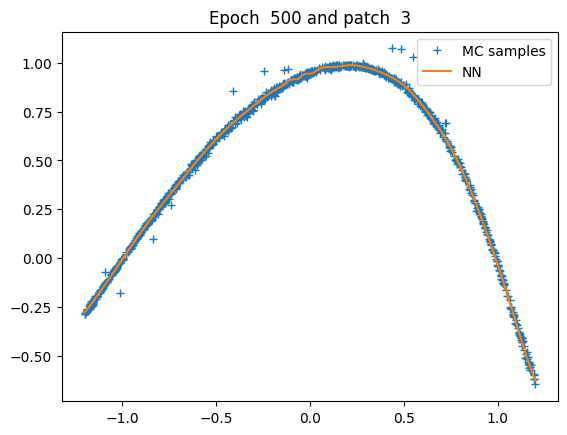

Patch  3: epoch 1000 with loss 2.69E-04


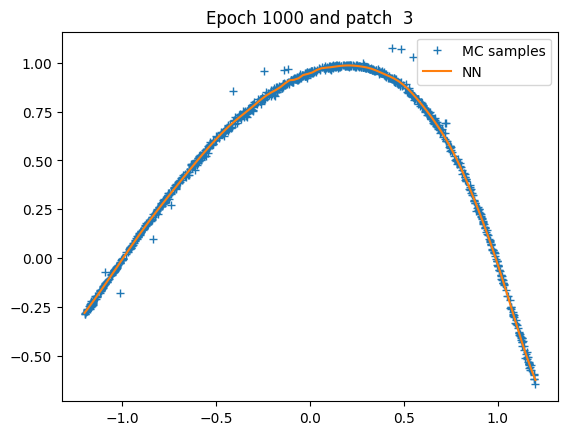

Patch  3: epoch 1500 with loss 2.69E-04


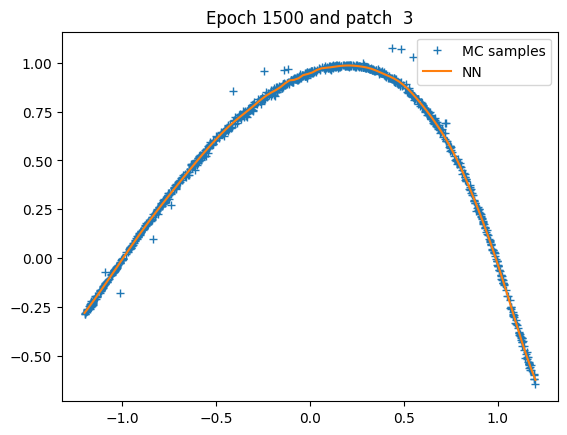

Patch  3: epoch 2000 with loss 2.69E-04


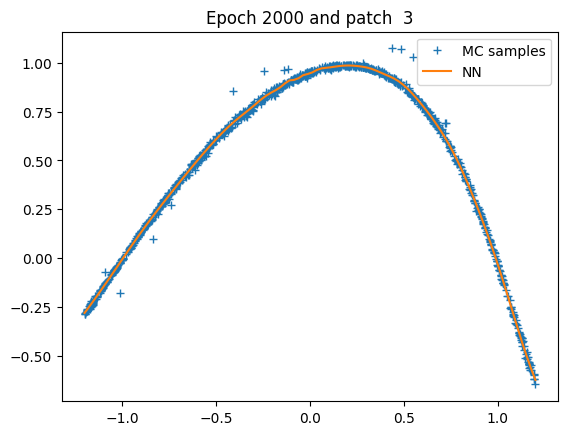

Patch  3: epoch 2499 with loss 2.69E-04


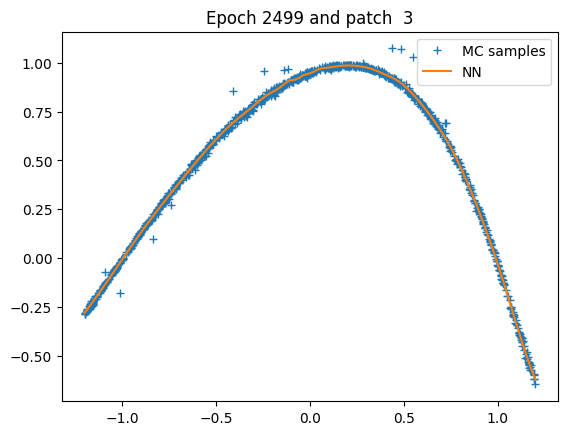

Patch 3: training of u with 2500 epochs take 20.06086826324463 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 92 seconds; L1 error: 2.07E-02; L2 error: 5.30E-04; rel error: INF.
fdb runtime: 0 seconds; total runtime: 92 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


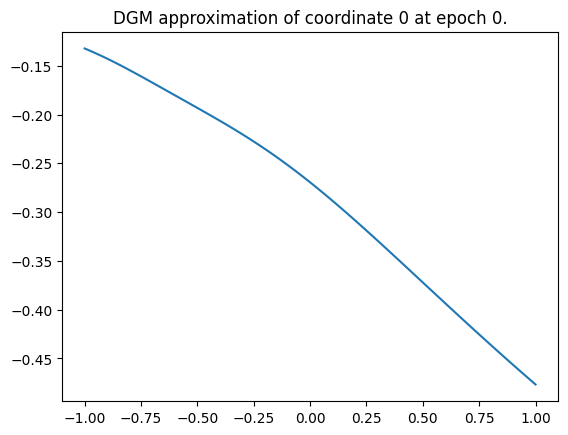

Epoch 0 with loss 1.7475074529647827


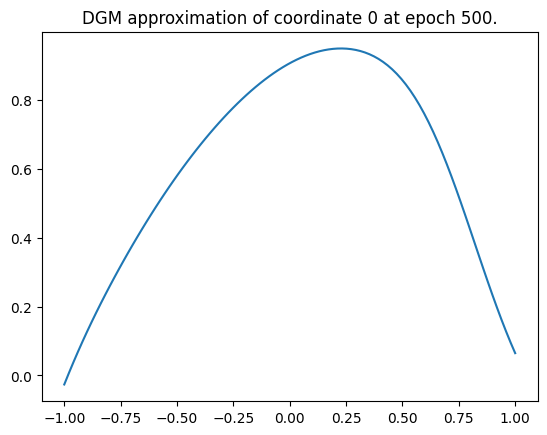

Epoch 500 with loss 0.002627368550747633


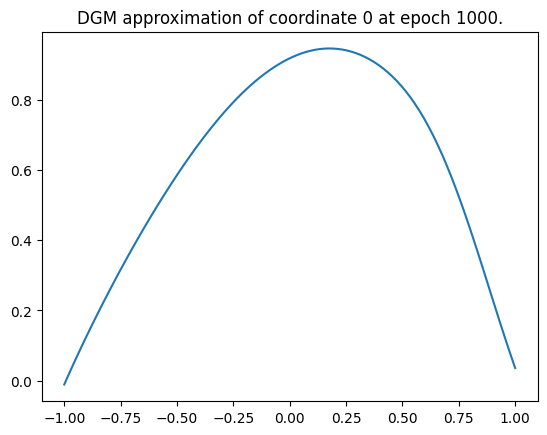

Epoch 1000 with loss 0.0008564505260437727


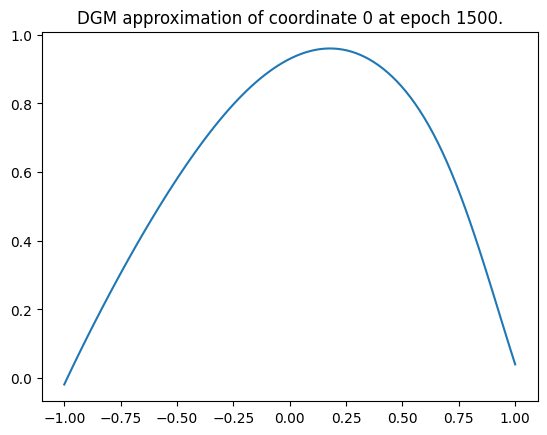

Epoch 1500 with loss 0.0006733964546583593


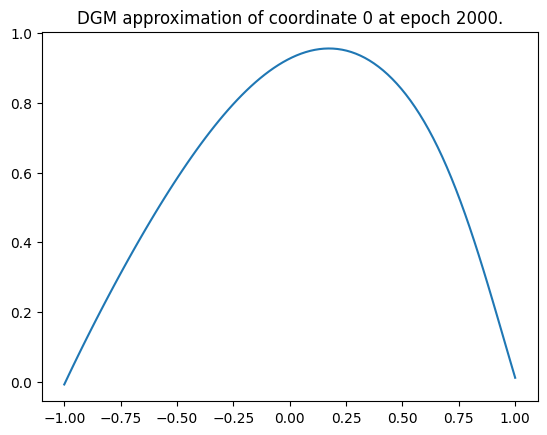

Epoch 2000 with loss 0.00032194689265452325


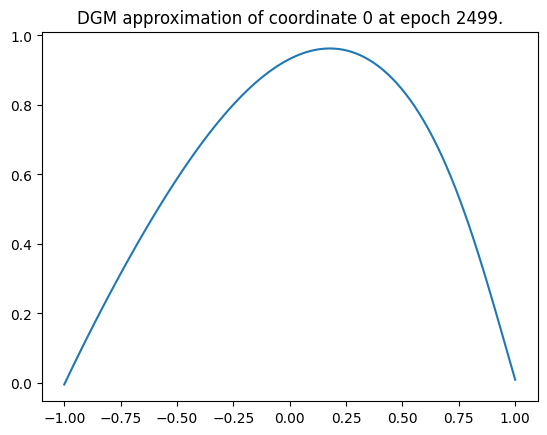

Epoch 2499 with loss 0.00012111561954952776
Training of neural network with 2500 epochs take 94.63089442253113 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 95 seconds; L1 error: 1.89E-03; L2 error: 6.47E-06; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


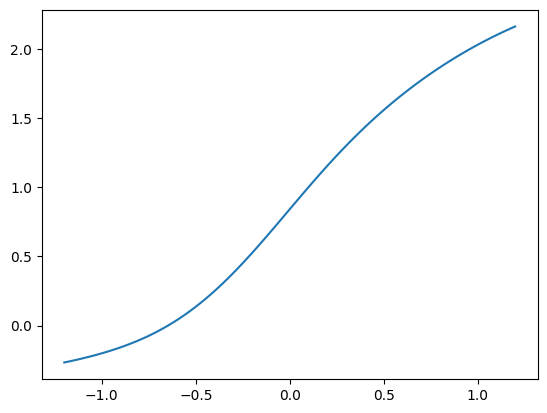

Epoch 0 with loss 1.1392133235931396


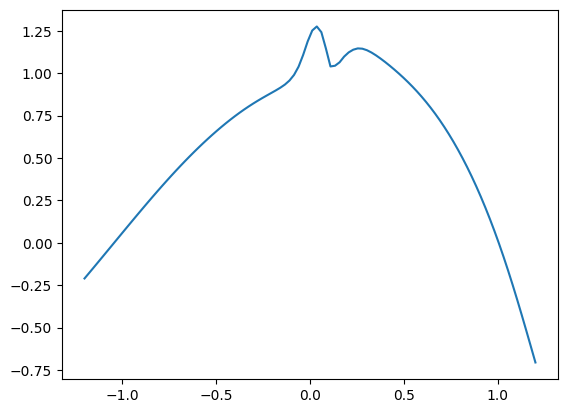

Epoch 500 with loss 0.0017263881163671613


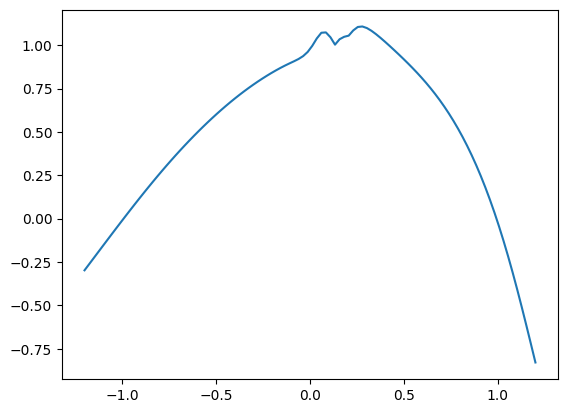

Epoch 1000 with loss 0.00040545265073888004


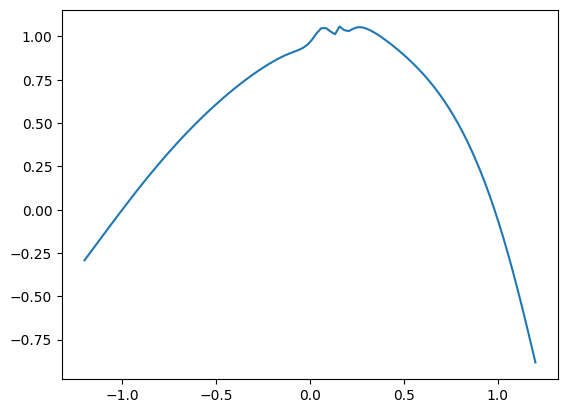

Epoch 1500 with loss 0.001055063446983695


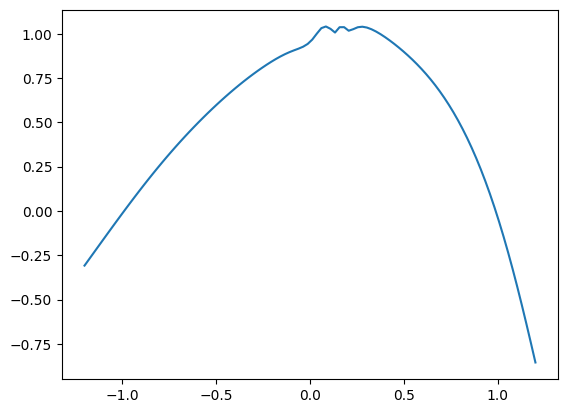

Epoch 2000 with loss 0.0009209318086504936


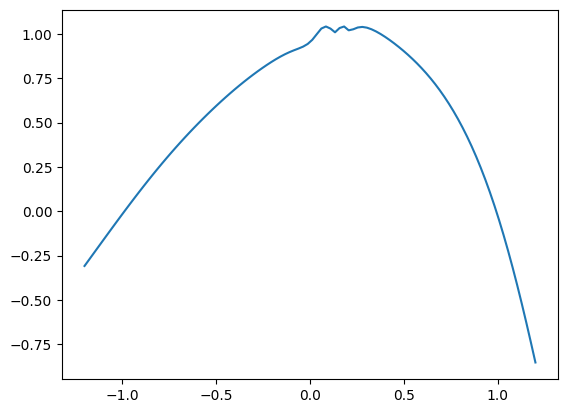

Epoch 2499 with loss 0.0009784544818103313
Training of neural network with 2500 epochs take 148.91633129119873 seconds.
Time taken: 149 seconds; L1 error: 3.37E-02; L2 error: 1.98E-03; rel error: INF.




######## Summary for deep branching method
runtime:        92
fdb runtime:    0
total runtime:  92
mean L1 error:  2.07E-02
std L1 error:   0.00E+00
mean L2 error:  5.30E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        95
mean L1 error:  1.89E-03
std L1 error:   0.00E+00
mean L2 error:  6.47E-06
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        149
mean L1 error:  3.37E-02
std L1 error:   0.00E+00
mean L2 error:  1.98E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


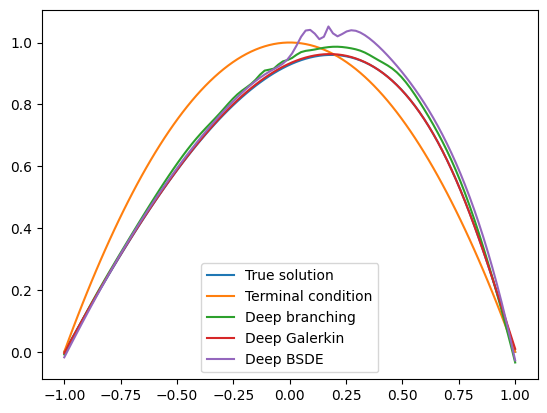

In [6]:
dim = 1
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,                     
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=4, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 2

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 14.772248029708862 seconds.
Patch  0: epoch    0 with loss 9.20E-01


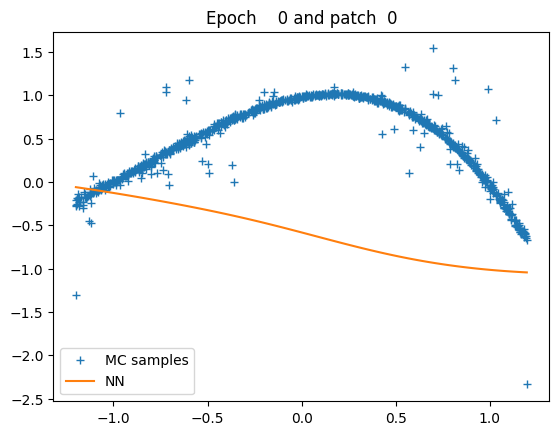

Patch  0: epoch  500 with loss 1.42E-02


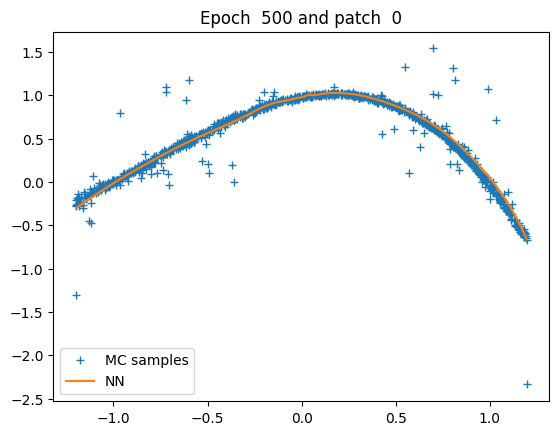

Patch  0: epoch 1000 with loss 1.82E-02


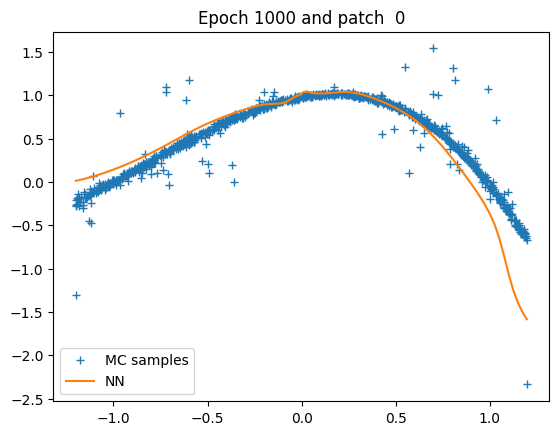

Patch  0: epoch 1500 with loss 1.41E-02


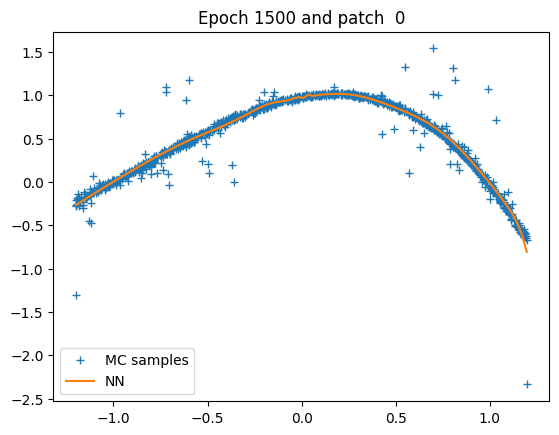

Patch  0: epoch 2000 with loss 1.40E-02


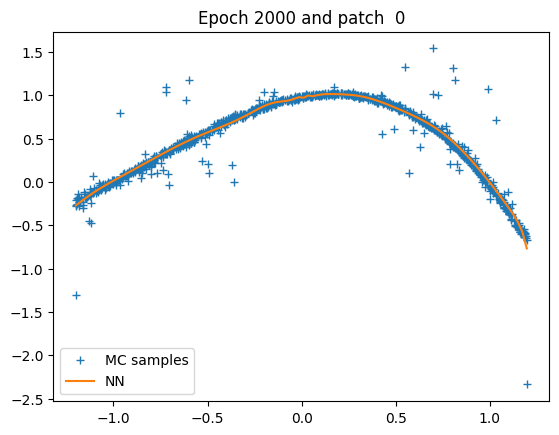

Patch  0: epoch 2499 with loss 1.39E-02


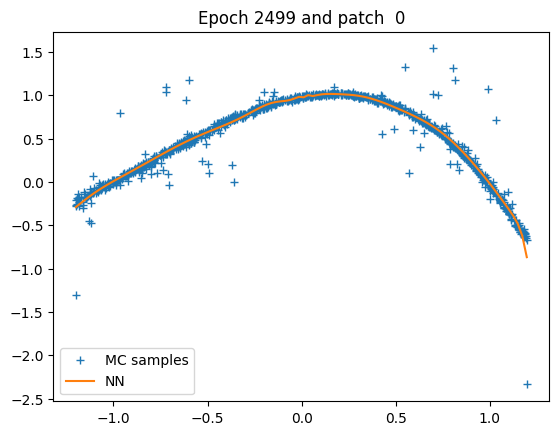

Patch 0: training of u with 2500 epochs take 17.694828033447266 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 32 seconds; L1 error: 2.32E-02; L2 error: 9.08E-04; rel error: INF.
fdb runtime: 0 seconds; total runtime: 33 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


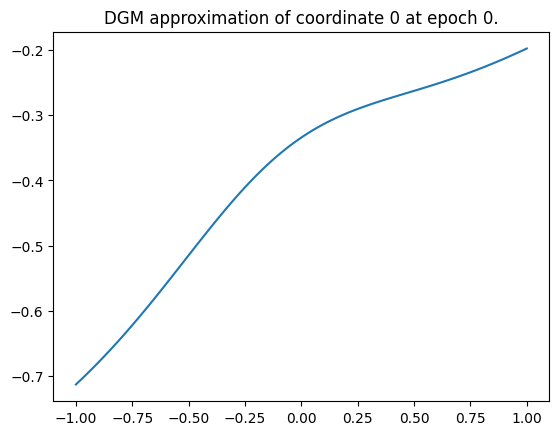

Epoch 0 with loss 3.4276251792907715


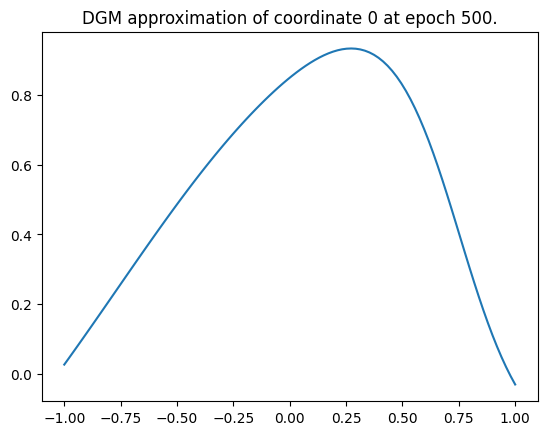

Epoch 500 with loss 0.3012741506099701


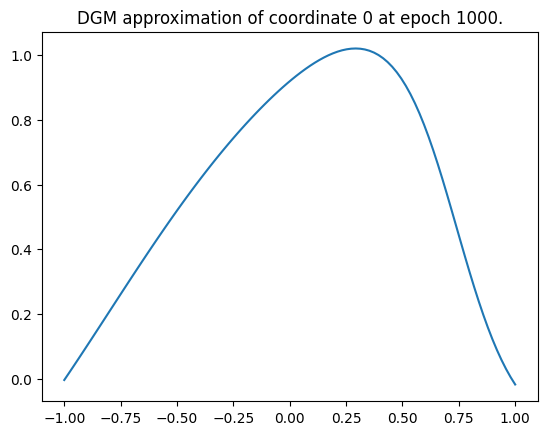

Epoch 1000 with loss 0.26296424865722656


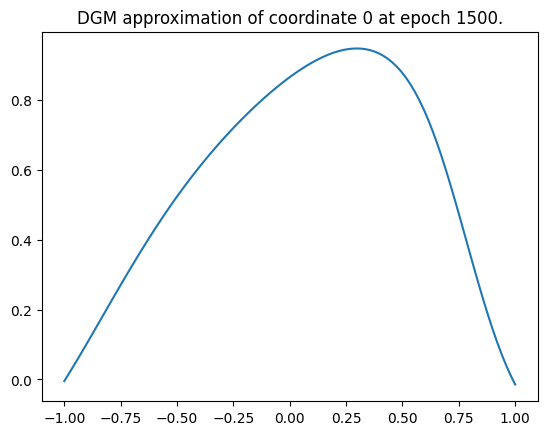

Epoch 1500 with loss 0.25156500935554504


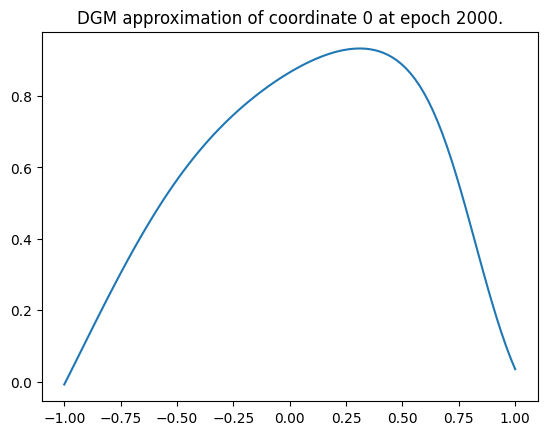

Epoch 2000 with loss 0.24783247709274292


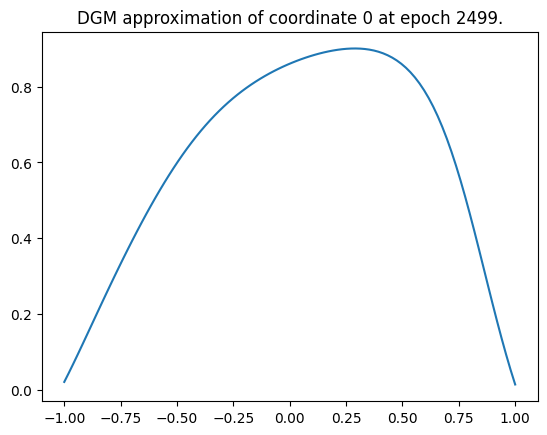

Epoch 2499 with loss 0.23024675250053406
Training of neural network with 2500 epochs take 144.73607301712036 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 145 seconds; L1 error: 2.92E-02; L2 error: 1.29E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


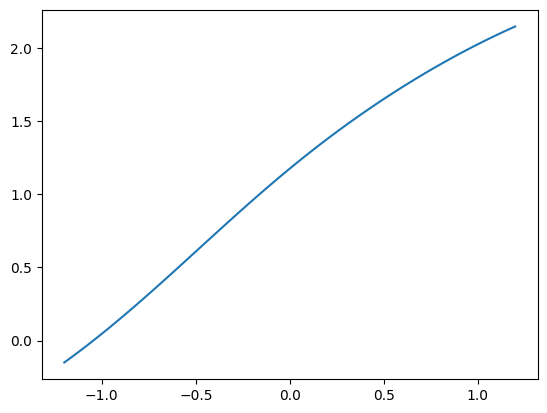

Epoch 0 with loss 1.7788124084472656


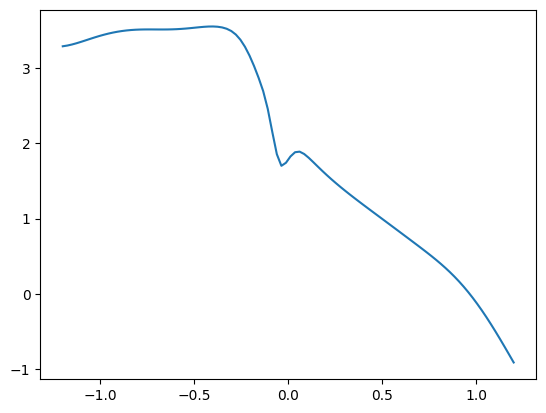

Epoch 500 with loss 0.07969692349433899


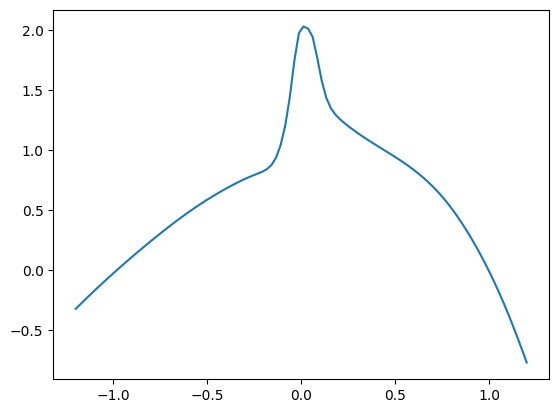

Epoch 1000 with loss 0.0010238016257062554


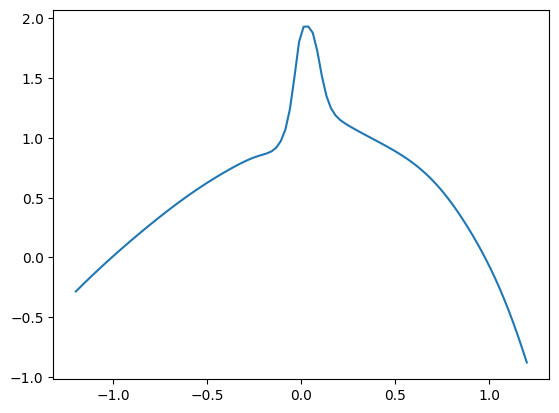

Epoch 1500 with loss 0.0012265397235751152


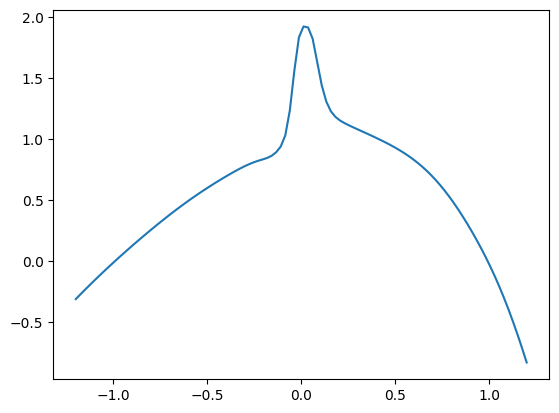

Epoch 2000 with loss 0.0007273014052771032


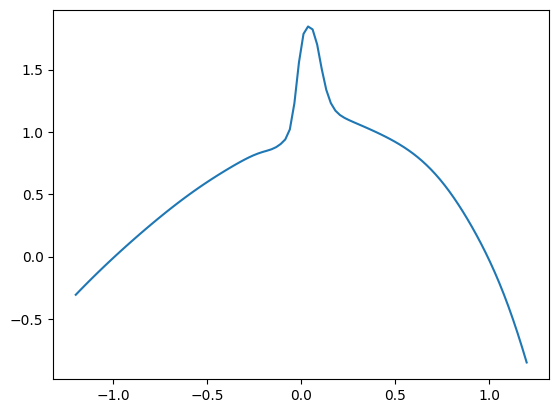

Epoch 2499 with loss 0.0008852363098412752
Training of neural network with 2500 epochs take 150.99862790107727 seconds.
Time taken: 151 seconds; L1 error: 1.05E-01; L2 error: 5.05E-02; rel error: INF.




######## Summary for deep branching method
runtime:        32
fdb runtime:    0
total runtime:  33
mean L1 error:  2.32E-02
std L1 error:   0.00E+00
mean L2 error:  9.08E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        145
mean L1 error:  2.92E-02
std L1 error:   0.00E+00
mean L2 error:  1.29E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        151
mean L1 error:  1.05E-01
std L1 error:   0.00E+00
mean L2 error:  5.05E-02
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


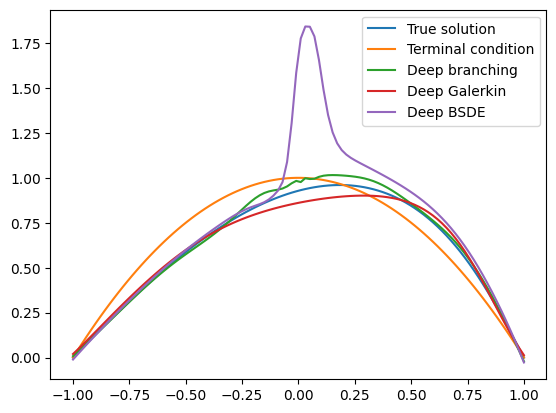

In [7]:
dim = 2
T=0.1/dim

grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 3

Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


#### Starting deep branching method with seed 0 - 1 out of 1 times
Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 28.307732582092285 seconds.
Patch  0: epoch    0 with loss 2.89E+00


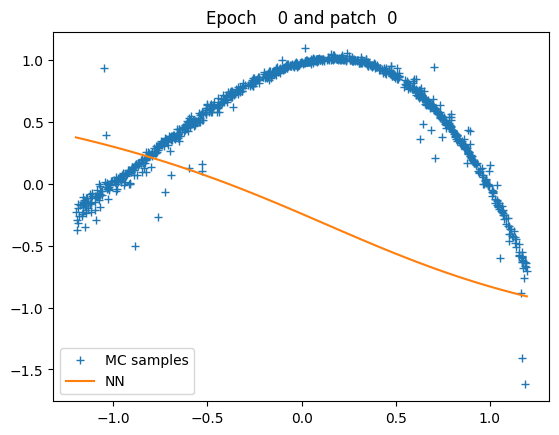

Patch  0: epoch  500 with loss 6.12E-03


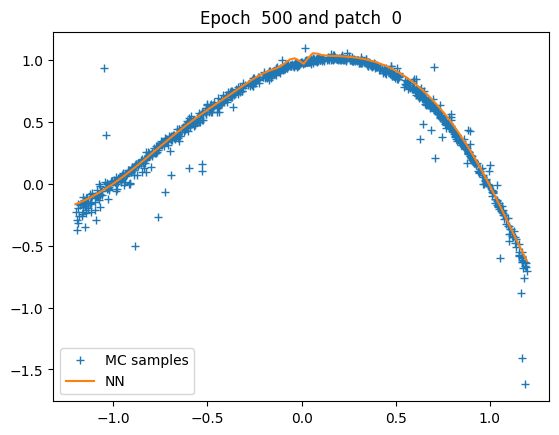

Patch  0: epoch 1000 with loss 5.63E-03


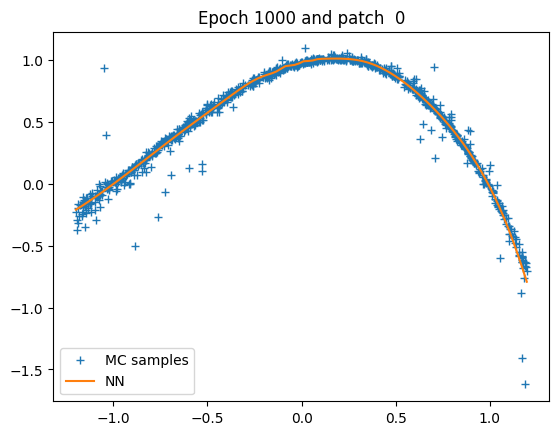

Patch  0: epoch 1500 with loss 5.62E-03


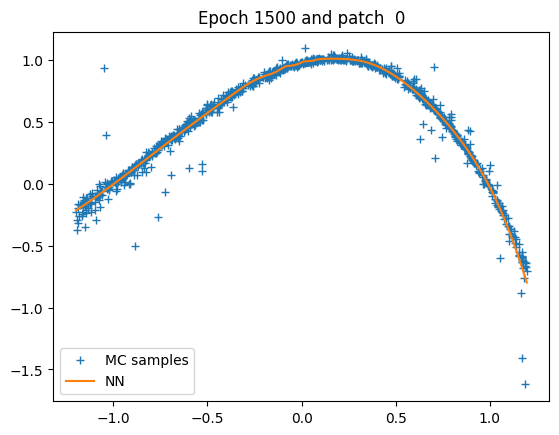

Patch  0: epoch 2000 with loss 5.61E-03


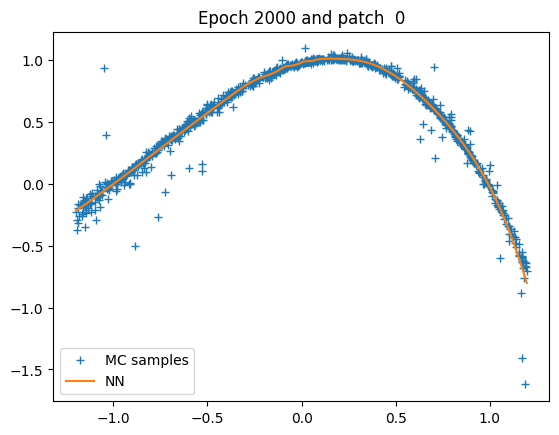

Patch  0: epoch 2499 with loss 5.61E-03


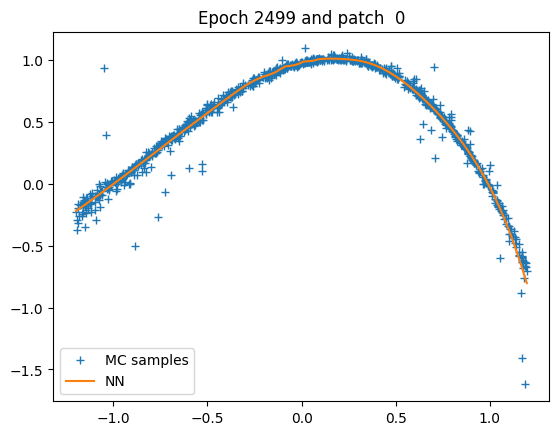

Patch 0: training of u with 2500 epochs take 18.4643771648407 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 45 seconds; L1 error: 2.68E-02; L2 error: 1.05E-03; rel error: INF.
fdb runtime: 2 seconds; total runtime: 47 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


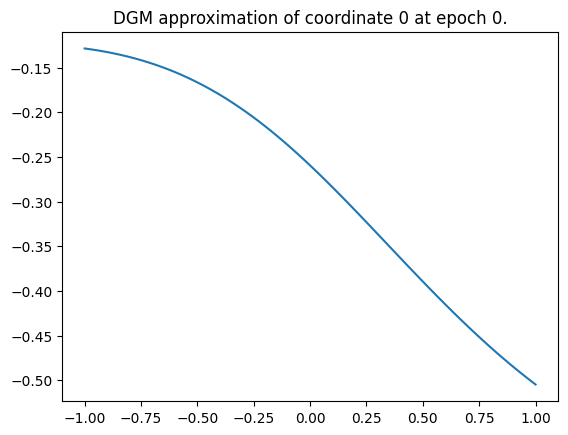

Epoch 0 with loss 2.438122272491455


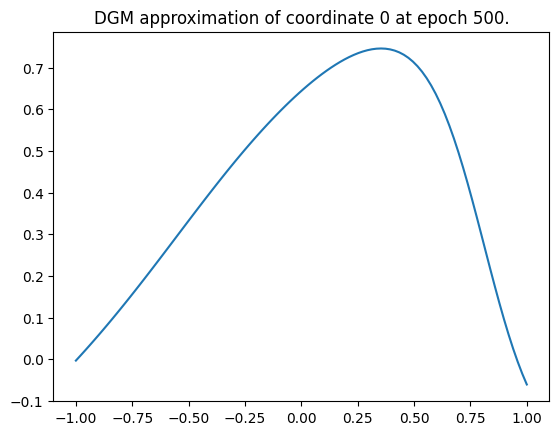

Epoch 500 with loss 0.9529133439064026


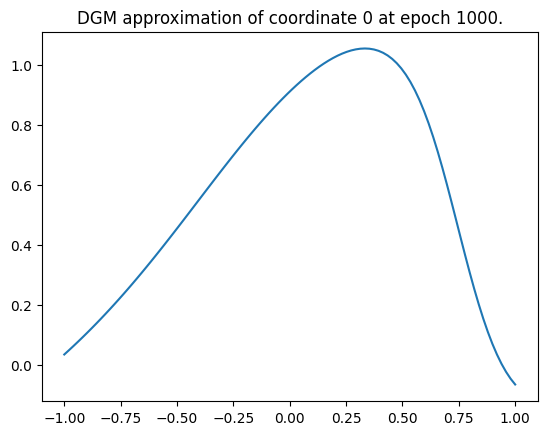

Epoch 1000 with loss 0.8967686891555786


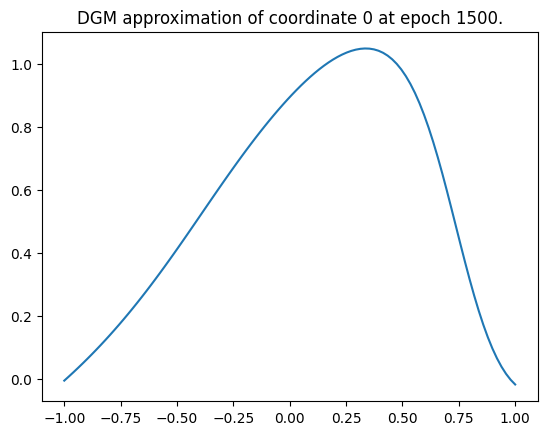

Epoch 1500 with loss 0.837488055229187


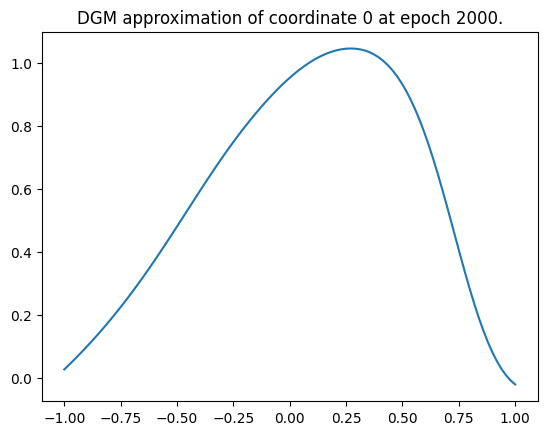

Epoch 2000 with loss 0.9769413471221924


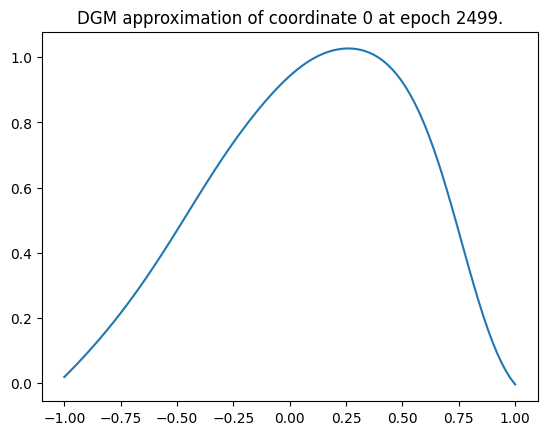

Epoch 2499 with loss 0.9024653434753418
Training of neural network with 2500 epochs take 194.84100103378296 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 195 seconds; L1 error: 6.73E-02; L2 error: 5.84E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


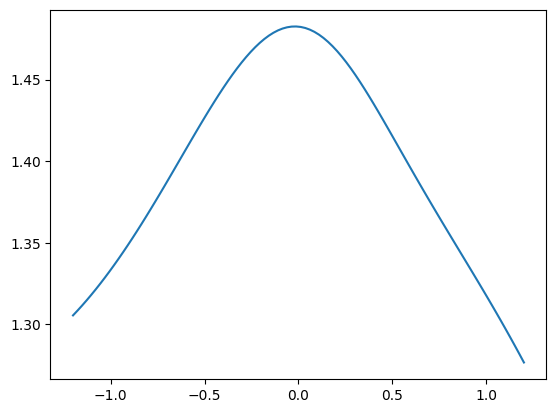

Epoch 0 with loss 1.3599494695663452


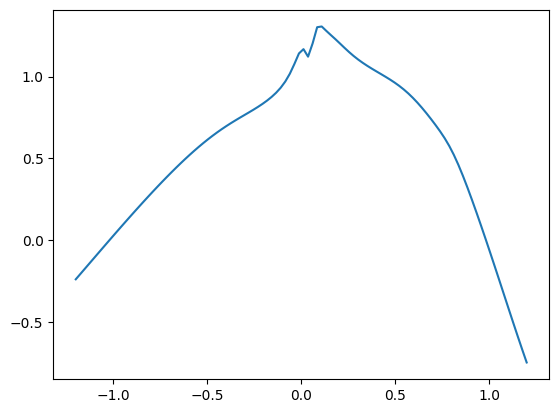

Epoch 500 with loss 0.0034201121889054775


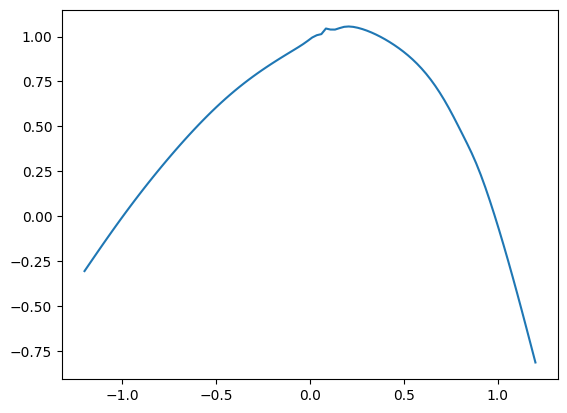

Epoch 1000 with loss 0.0016886410303413868


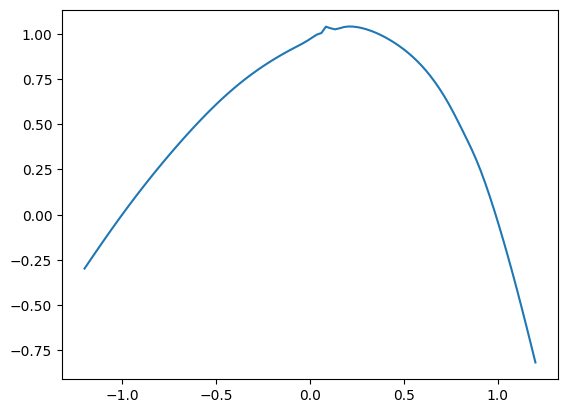

Epoch 1500 with loss 0.0017349295085296035


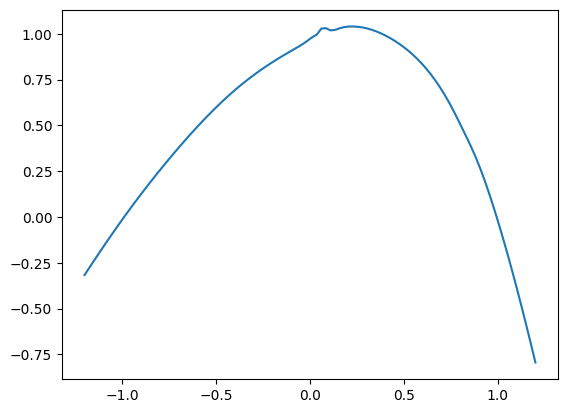

Epoch 2000 with loss 0.0008276777807623148


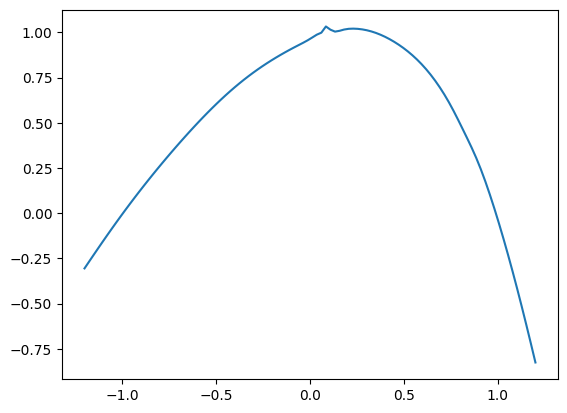

Epoch 2499 with loss 0.0007103984826244414
Training of neural network with 2500 epochs take 150.24535250663757 seconds.
Time taken: 150 seconds; L1 error: 3.51E-02; L2 error: 1.83E-03; rel error: INF.




######## Summary for deep branching method
runtime:        45
fdb runtime:    2
total runtime:  47
mean L1 error:  2.68E-02
std L1 error:   0.00E+00
mean L2 error:  1.05E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        195
mean L1 error:  6.73E-02
std L1 error:   0.00E+00
mean L2 error:  5.84E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        150
mean L1 error:  3.51E-02
std L1 error:   0.00E+00
mean L2 error:  1.83E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


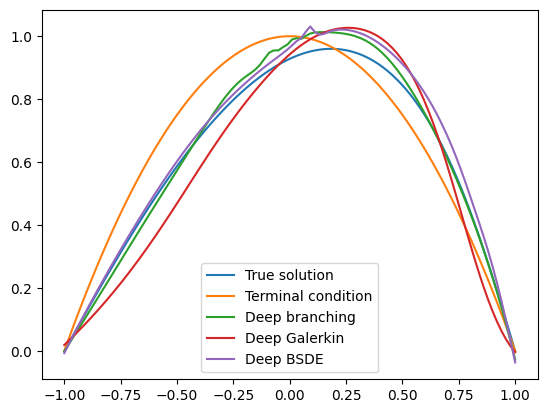

In [8]:
dim = 3
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 4

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 47.13229012489319 seconds.
Patch  0: epoch    0 with loss 5.03E-01


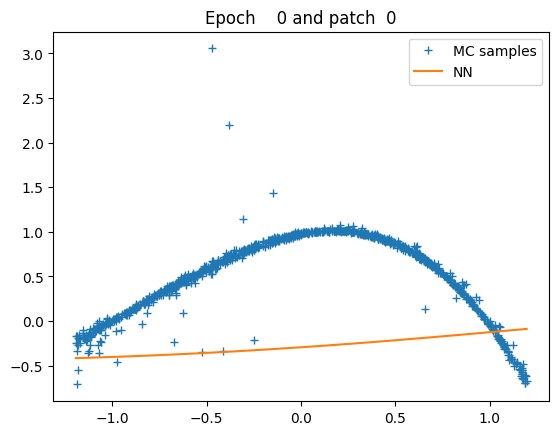

Patch  0: epoch  500 with loss 1.38E-02


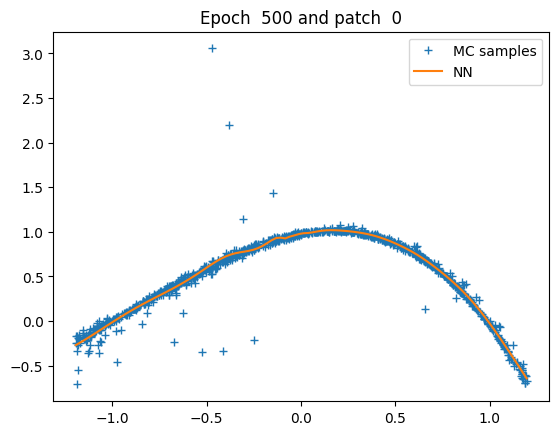

Patch  0: epoch 1000 with loss 1.38E-02


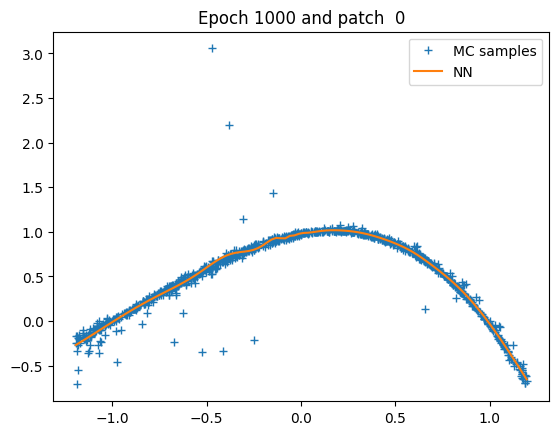

Patch  0: epoch 1500 with loss 1.38E-02


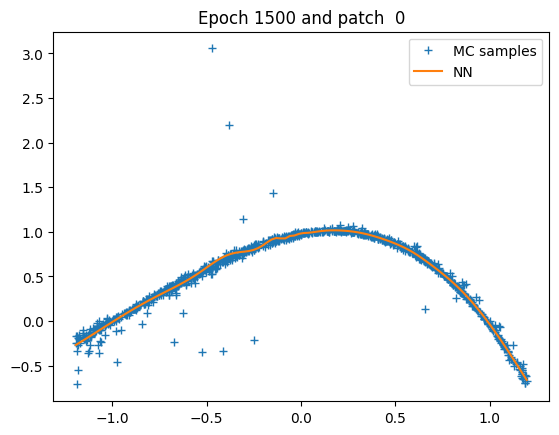

Patch  0: epoch 2000 with loss 1.38E-02


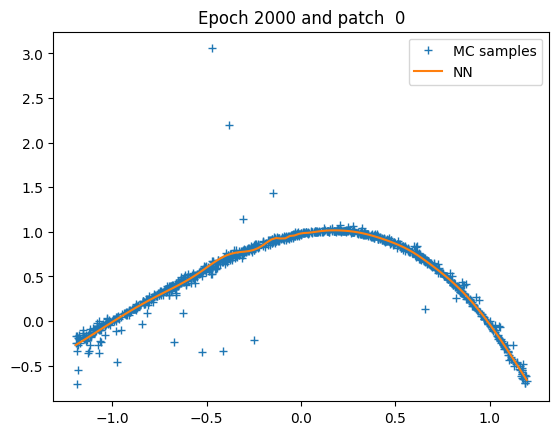

Patch  0: epoch 2499 with loss 1.38E-02


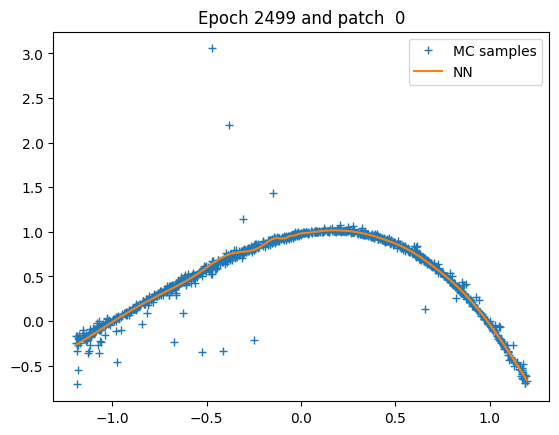

Patch 0: training of u with 2500 epochs take 18.310955047607422 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 60 seconds; L1 error: 2.67E-02; L2 error: 1.08E-03; rel error: INF.
fdb runtime: 6 seconds; total runtime: 66 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


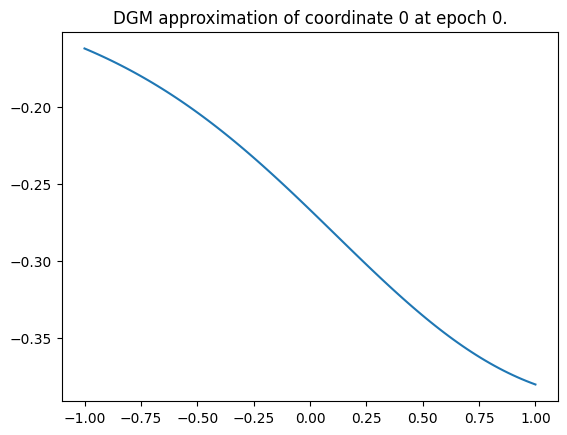

Epoch 0 with loss 3.533560037612915


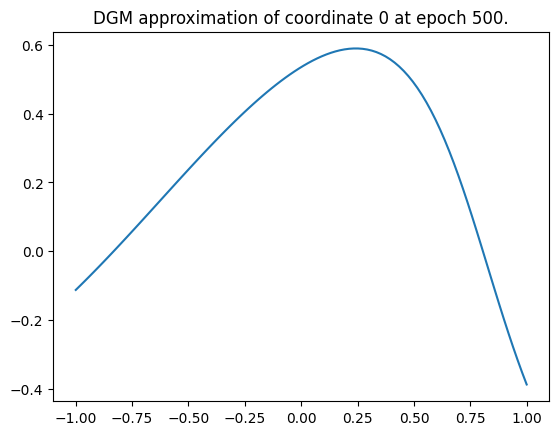

Epoch 500 with loss 1.9180524349212646


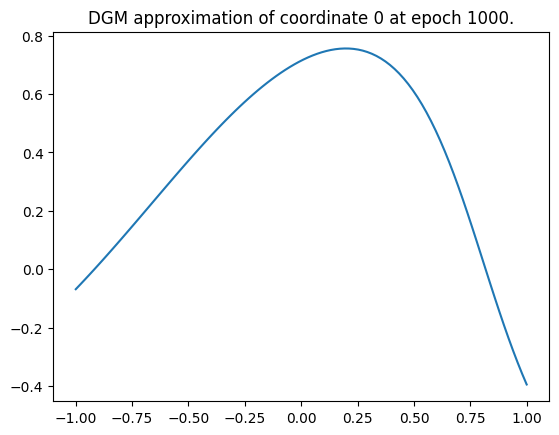

Epoch 1000 with loss 1.767902135848999


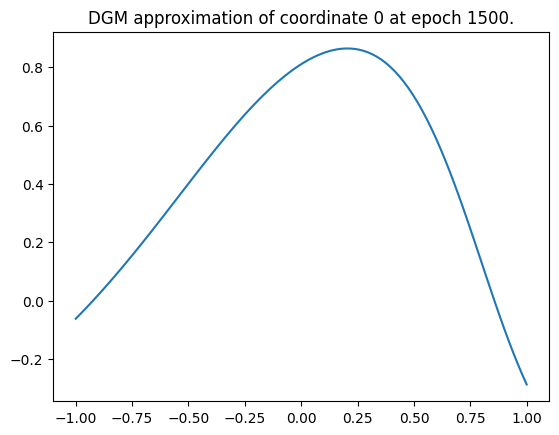

Epoch 1500 with loss 1.9101903438568115


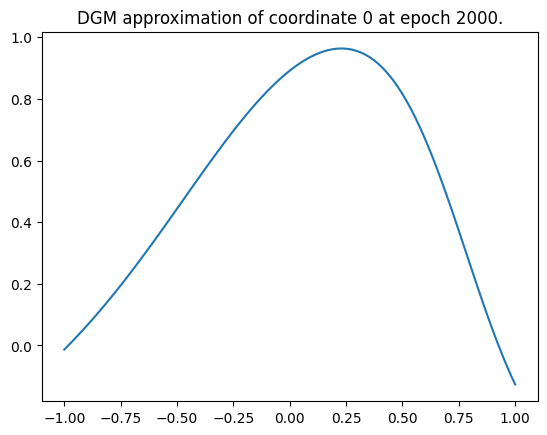

Epoch 2000 with loss 2.107570171356201


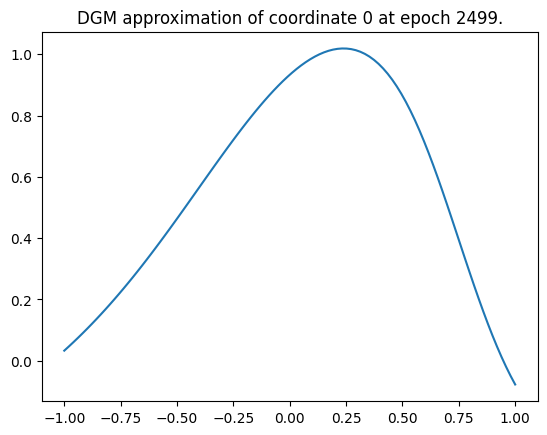

Epoch 2499 with loss 1.8907140493392944
Training of neural network with 2500 epochs take 245.2074954509735 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 245 seconds; L1 error: 7.44E-02; L2 error: 7.56E-03; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


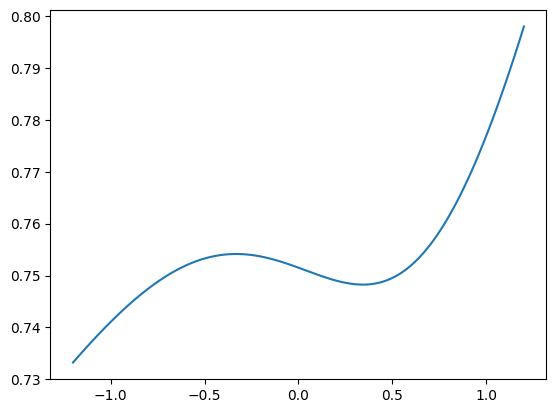

Epoch 0 with loss 1.5398199558258057


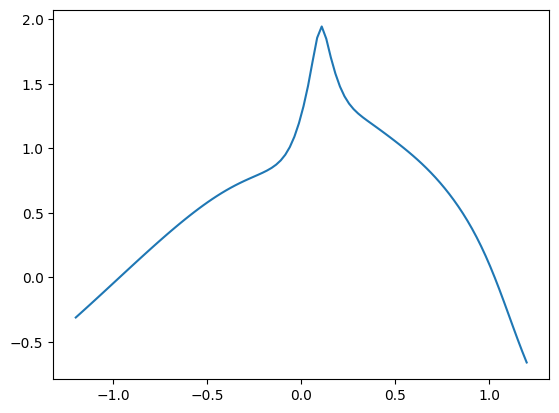

Epoch 500 with loss 0.0030822015833109617


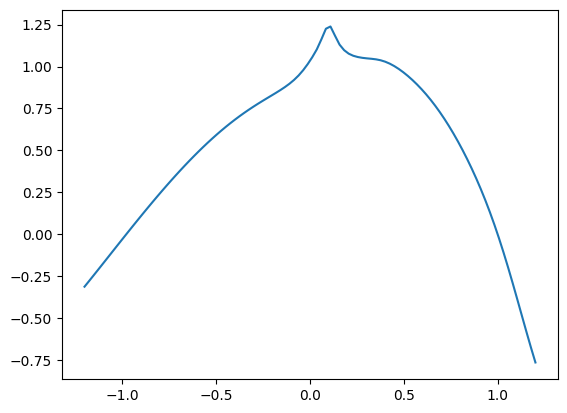

Epoch 1000 with loss 0.0024499555584043264


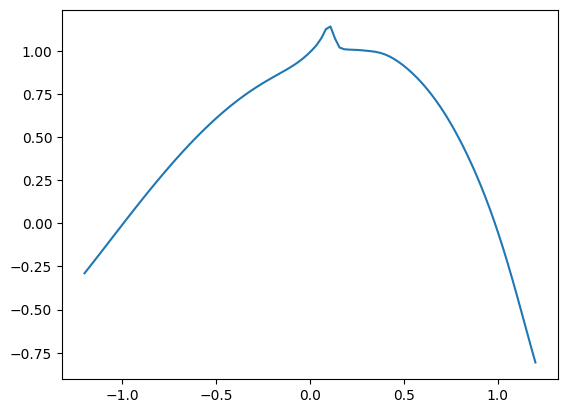

Epoch 1500 with loss 0.0009581775520928204


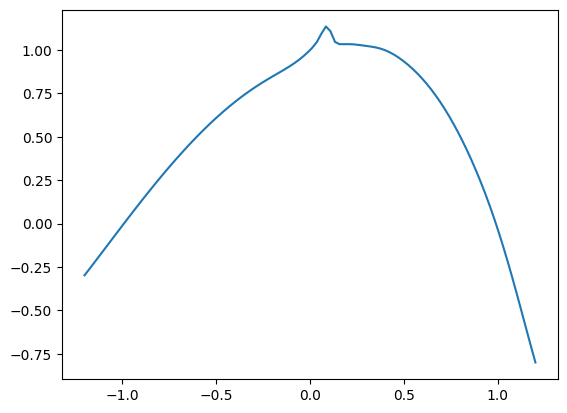

Epoch 2000 with loss 0.0014966632006689906


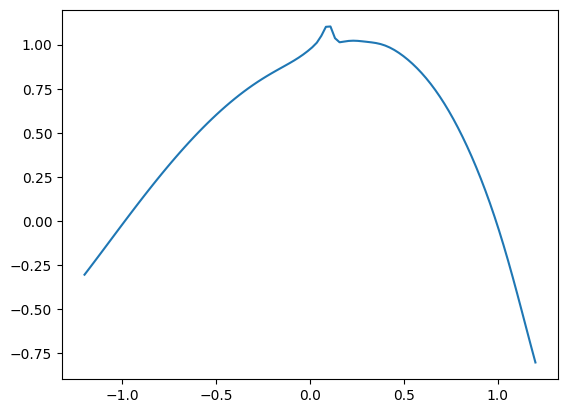

Epoch 2499 with loss 0.0007622222183272243
Training of neural network with 2500 epochs take 150.03083181381226 seconds.
Time taken: 150 seconds; L1 error: 4.13E-02; L2 error: 2.99E-03; rel error: INF.




######## Summary for deep branching method
runtime:        60
fdb runtime:    6
total runtime:  66
mean L1 error:  2.67E-02
std L1 error:   0.00E+00
mean L2 error:  1.08E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        245
mean L1 error:  7.44E-02
std L1 error:   0.00E+00
mean L2 error:  7.56E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        150
mean L1 error:  4.13E-02
std L1 error:   0.00E+00
mean L2 error:  2.99E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


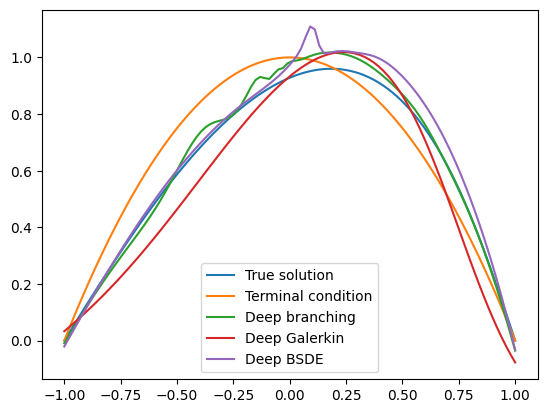

In [9]:
dim = 4
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 5

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 77.25249028205872 seconds.
Patch  0: epoch    0 with loss 2.61E+00


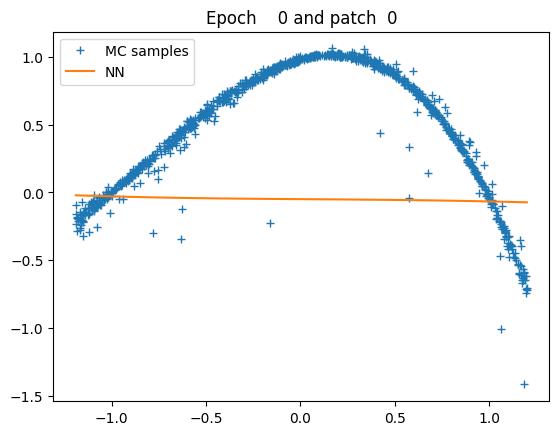

Patch  0: epoch  500 with loss 6.12E-03


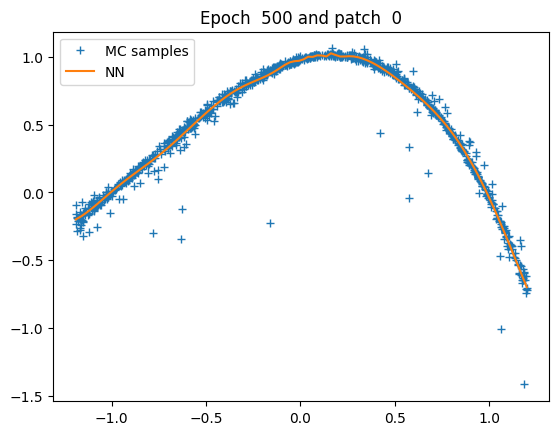

Patch  0: epoch 1000 with loss 6.11E-03


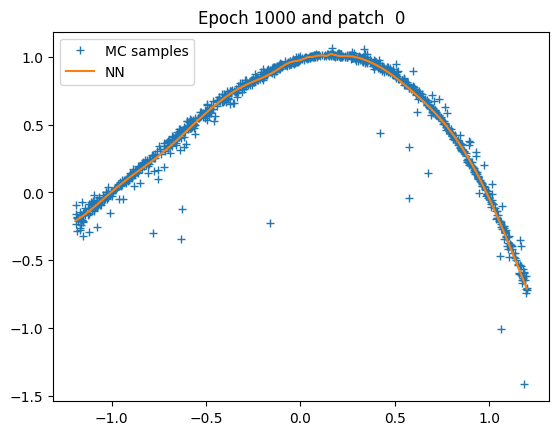

Patch  0: epoch 1500 with loss 6.11E-03


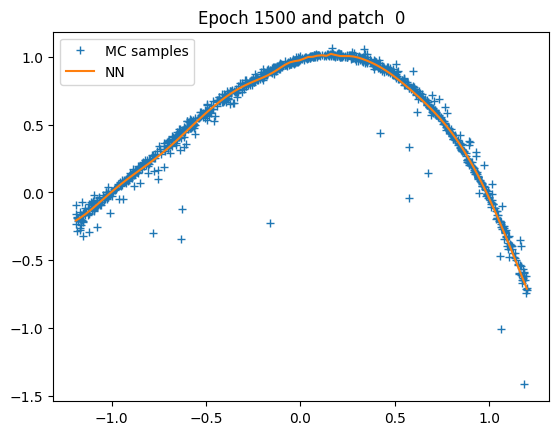

Patch  0: epoch 2000 with loss 6.11E-03


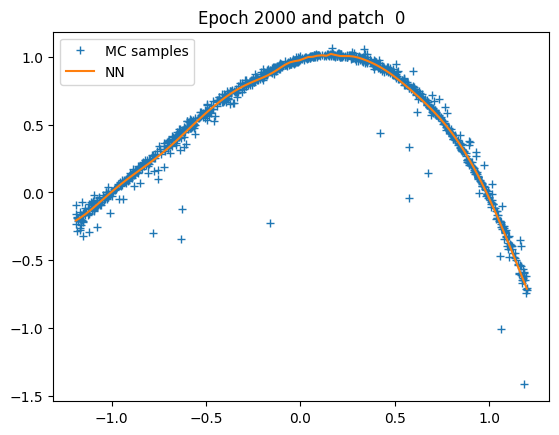

Patch  0: epoch 2499 with loss 6.11E-03


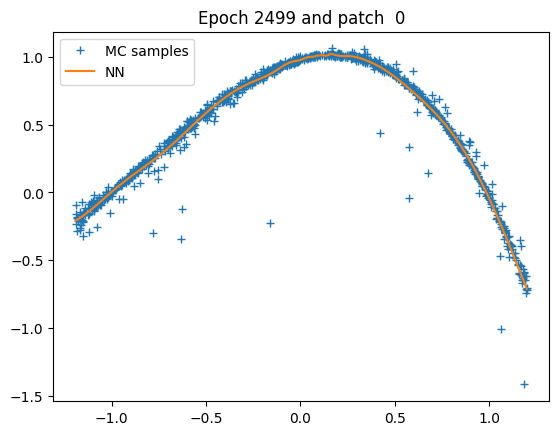

Patch 0: training of u with 2500 epochs take 18.24264144897461 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 76 seconds; L1 error: 2.57E-02; L2 error: 9.90E-04; rel error: INF.
fdb runtime: 20 seconds; total runtime: 96 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


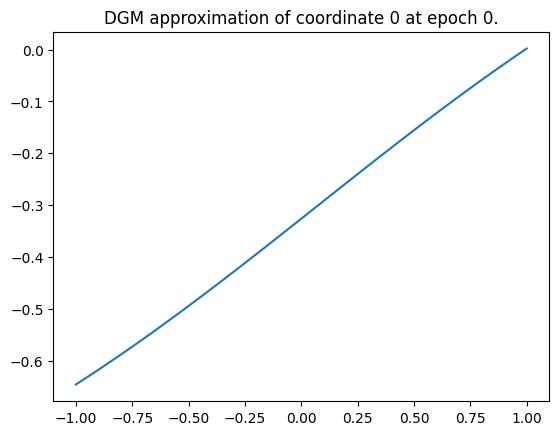

Epoch 0 with loss 5.829643249511719


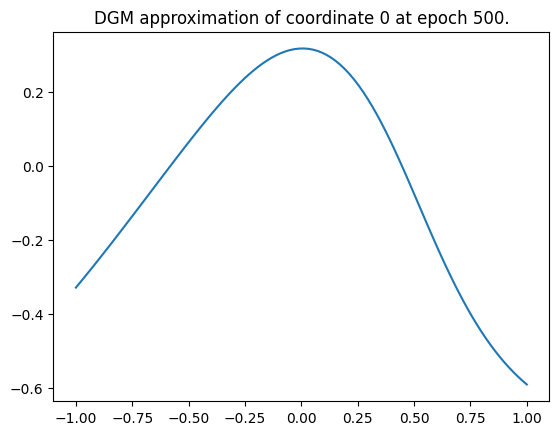

Epoch 500 with loss 3.405527114868164


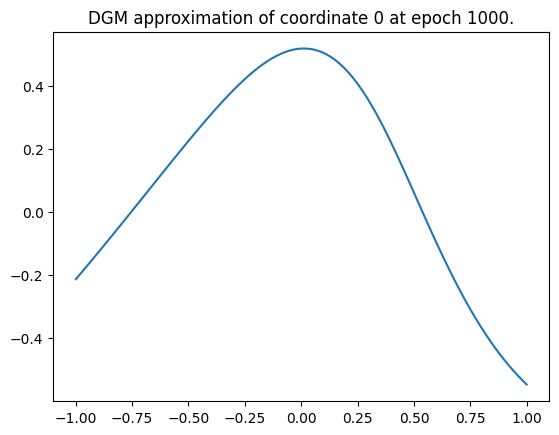

Epoch 1000 with loss 2.7264771461486816


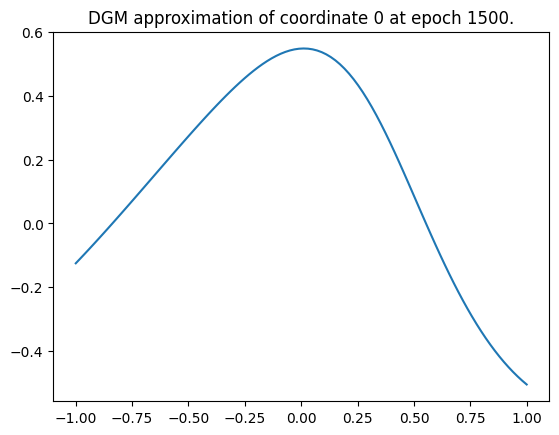

Epoch 1500 with loss 3.3123412132263184


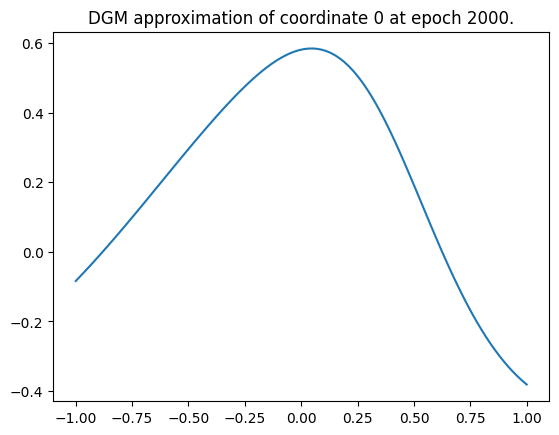

Epoch 2000 with loss 3.541045904159546


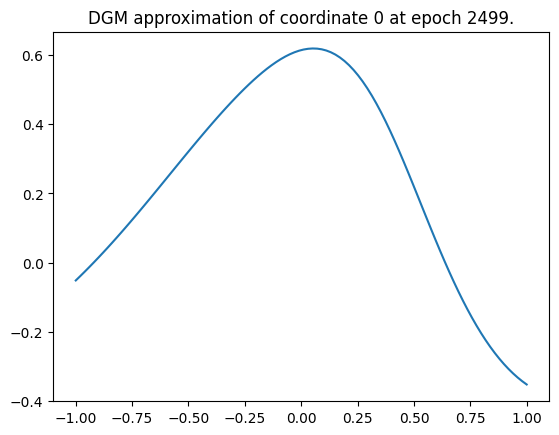

Epoch 2499 with loss 3.4090335369110107
Training of neural network with 2500 epochs take 286.82444405555725 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 287 seconds; L1 error: 3.79E-01; L2 error: 1.76E-01; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


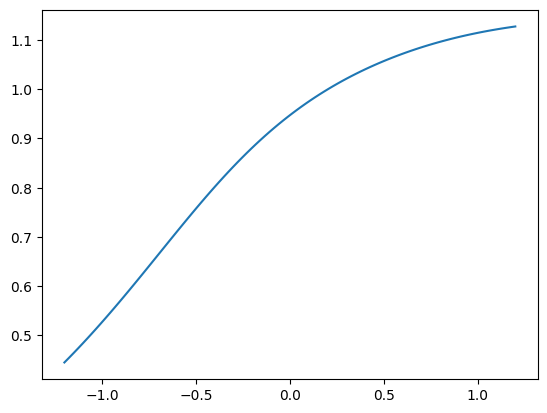

Epoch 0 with loss 1.3690115213394165


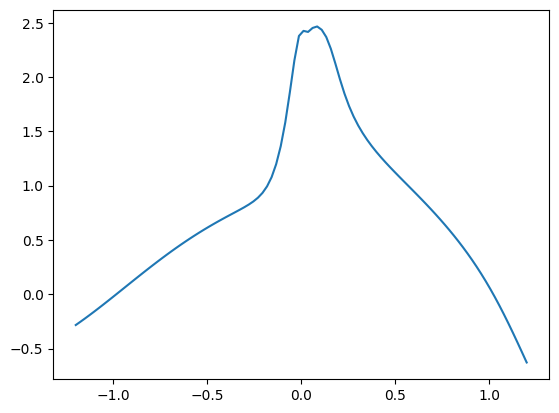

Epoch 500 with loss 0.014529259875416756


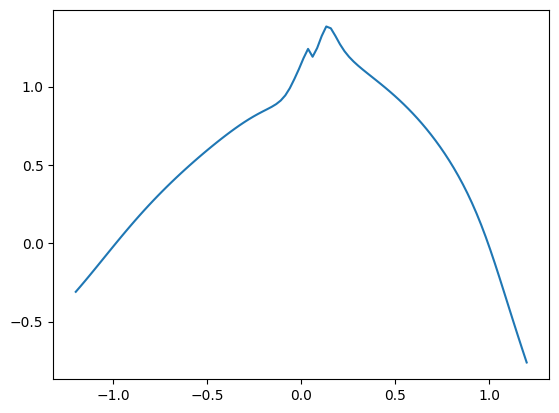

Epoch 1000 with loss 0.0010080869542434812


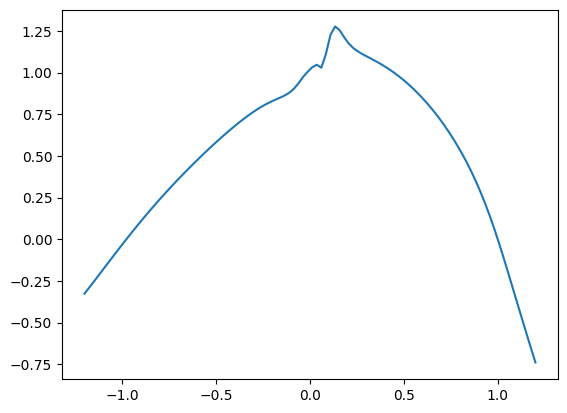

Epoch 1500 with loss 0.00436819065362215


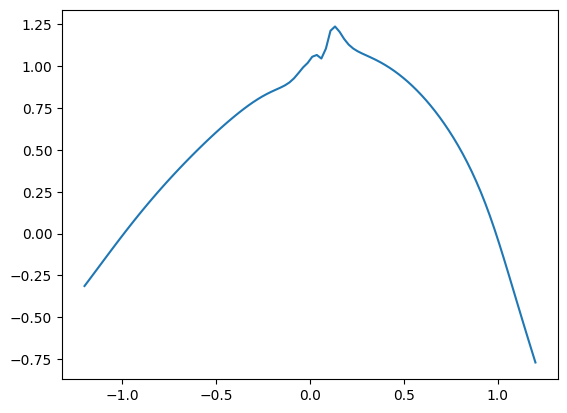

Epoch 2000 with loss 0.001217603450641036


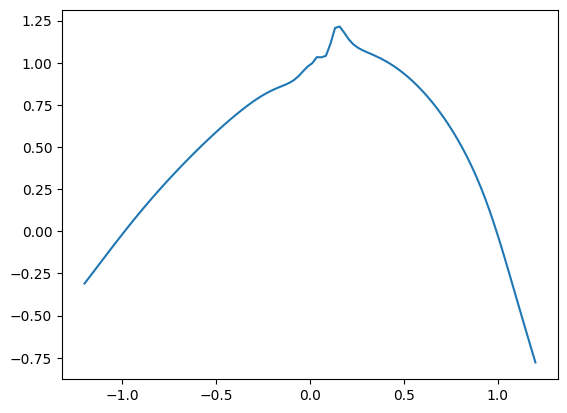

Epoch 2499 with loss 0.0016406968934461474
Training of neural network with 2500 epochs take 143.72185349464417 seconds.
Time taken: 144 seconds; L1 error: 5.31E-02; L2 error: 6.29E-03; rel error: INF.




######## Summary for deep branching method
runtime:        76
fdb runtime:    20
total runtime:  96
mean L1 error:  2.57E-02
std L1 error:   0.00E+00
mean L2 error:  9.90E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        287
mean L1 error:  3.79E-01
std L1 error:   0.00E+00
mean L2 error:  1.76E-01
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        144
mean L1 error:  5.31E-02
std L1 error:   0.00E+00
mean L2 error:  6.29E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


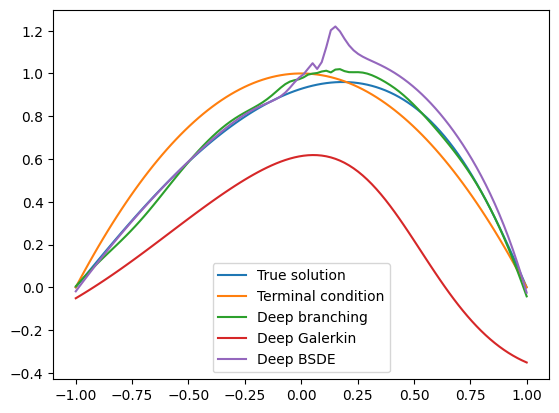

In [10]:
dim = 5
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 6

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 106.61424803733826 seconds.
Patch  0: epoch    0 with loss 4.52E+00


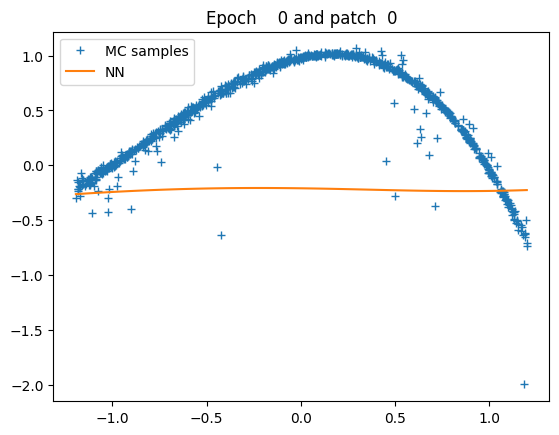

Patch  0: epoch  500 with loss 9.45E-03


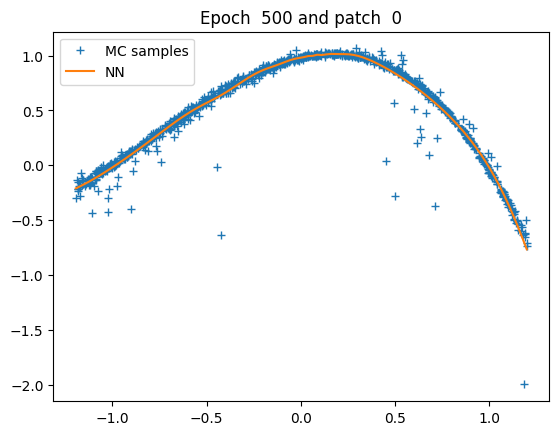

Patch  0: epoch 1000 with loss 9.44E-03


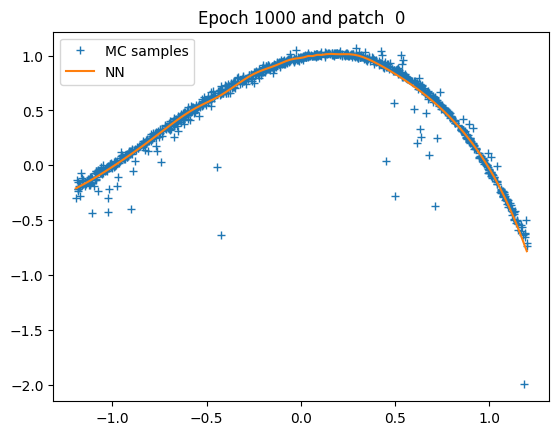

Patch  0: epoch 1500 with loss 9.44E-03


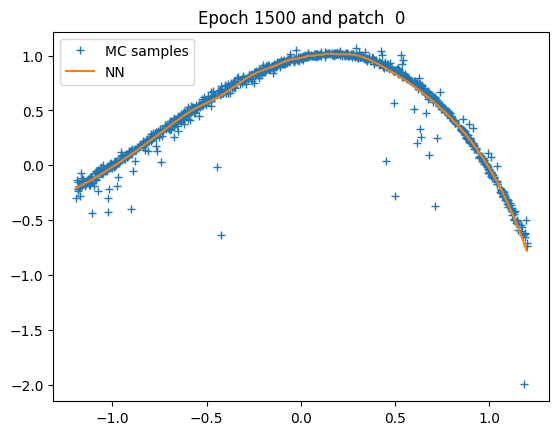

Patch  0: epoch 2000 with loss 9.44E-03


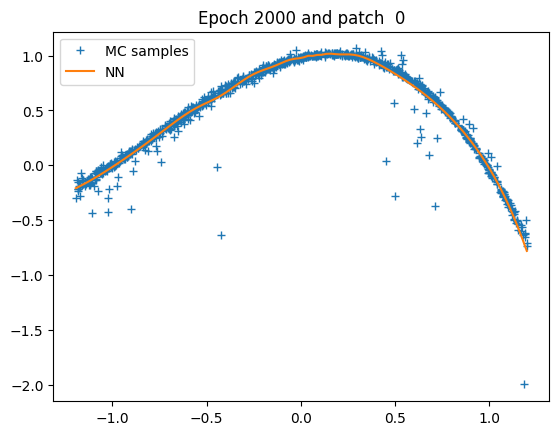

Patch  0: epoch 2499 with loss 9.44E-03


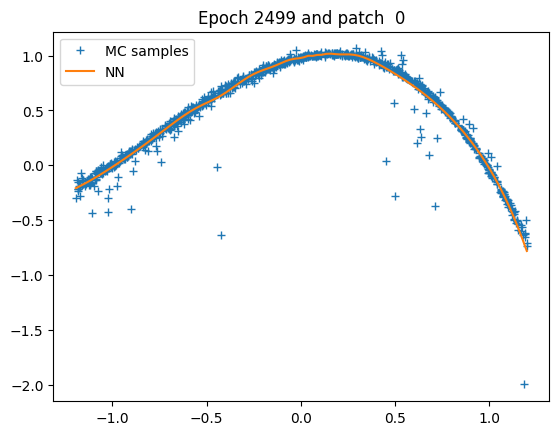

Patch 0: training of u with 2500 epochs take 17.495845556259155 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 106 seconds; L1 error: 2.83E-02; L2 error: 1.06E-03; rel error: INF.
fdb runtime: 19 seconds; total runtime: 125 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


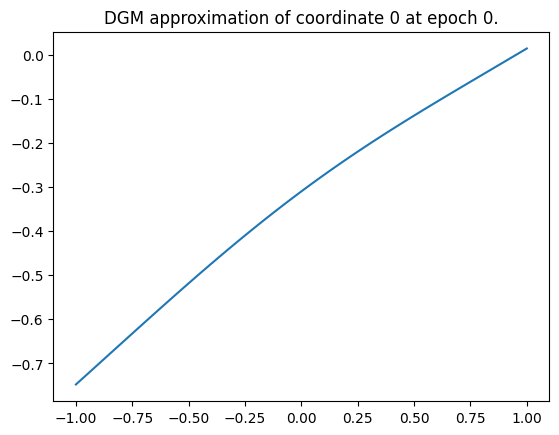

Epoch 0 with loss 9.213052749633789


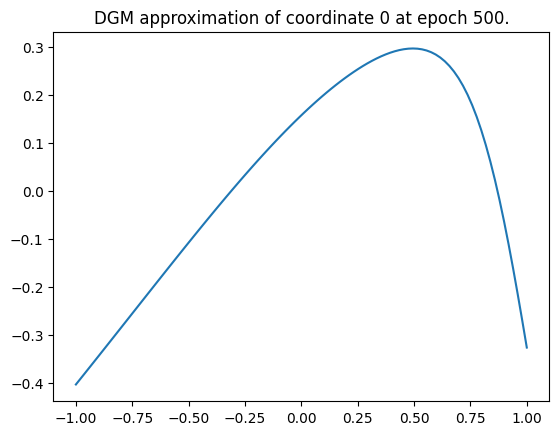

Epoch 500 with loss 6.145944118499756


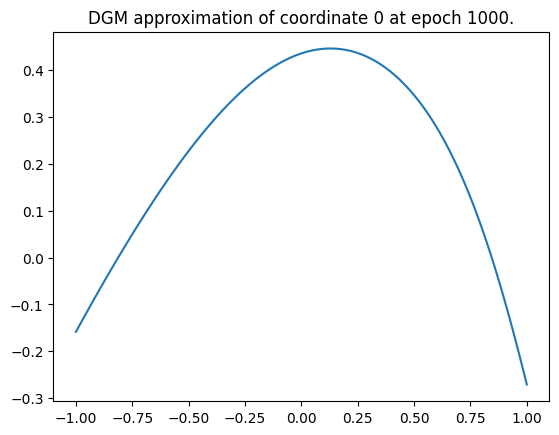

Epoch 1000 with loss 5.133083343505859


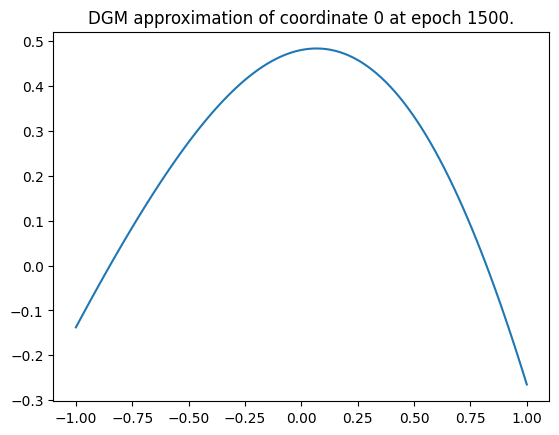

Epoch 1500 with loss 4.54249382019043


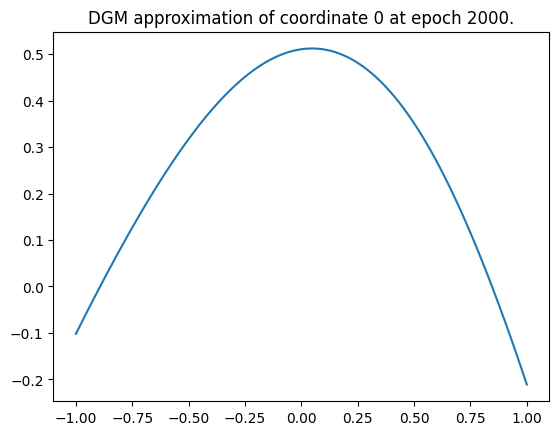

Epoch 2000 with loss 5.168208122253418


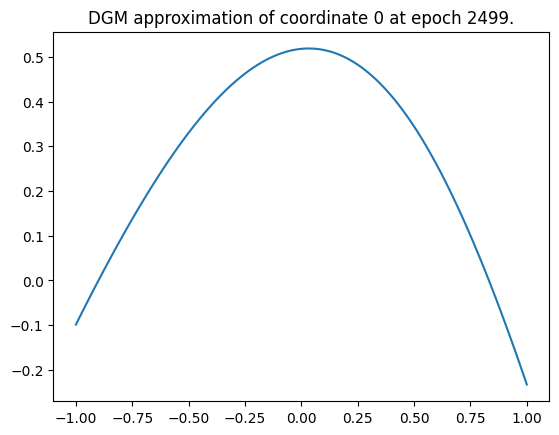

Epoch 2499 with loss 4.85193395614624
Training of neural network with 2500 epochs take 326.09248876571655 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 326 seconds; L1 error: 3.45E-01; L2 error: 1.34E-01; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


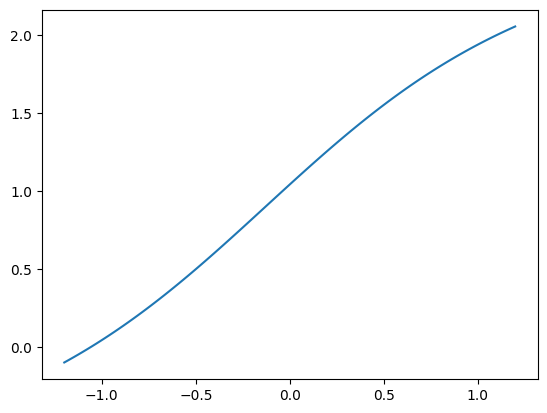

Epoch 0 with loss 1.14840567111969


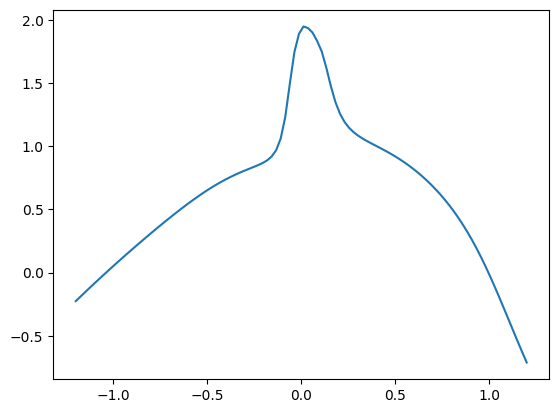

Epoch 500 with loss 0.00121502170804888


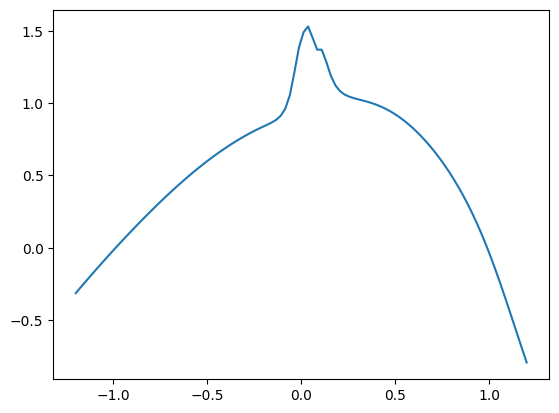

Epoch 1000 with loss 0.0007372140535153449


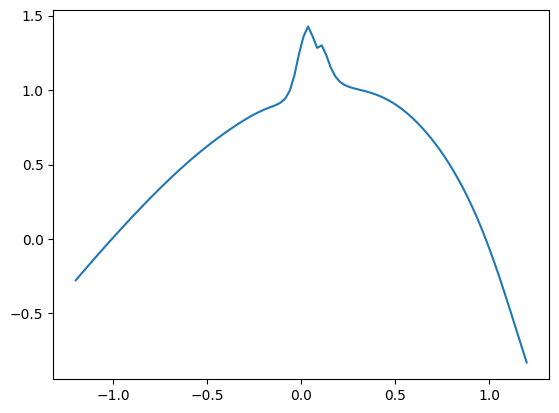

Epoch 1500 with loss 0.0009610009146854281


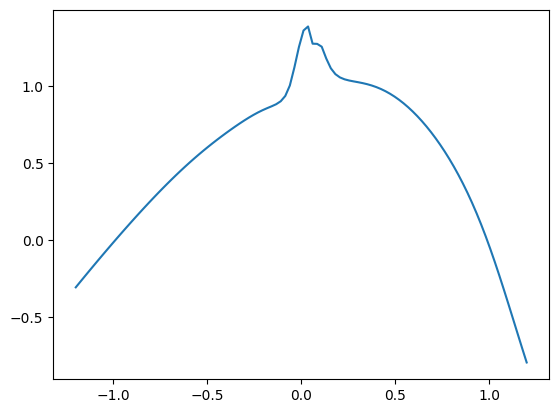

Epoch 2000 with loss 0.0007583917467854917


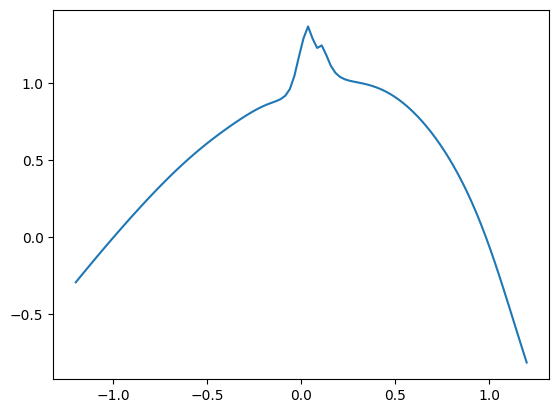

Epoch 2499 with loss 0.0020384849049150944
Training of neural network with 2500 epochs take 143.14981603622437 seconds.
Time taken: 143 seconds; L1 error: 6.14E-02; L2 error: 1.07E-02; rel error: INF.




######## Summary for deep branching method
runtime:        106
fdb runtime:    19
total runtime:  125
mean L1 error:  2.83E-02
std L1 error:   0.00E+00
mean L2 error:  1.06E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        326
mean L1 error:  3.45E-01
std L1 error:   0.00E+00
mean L2 error:  1.34E-01
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        143
mean L1 error:  6.14E-02
std L1 error:   0.00E+00
mean L2 error:  1.07E-02
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


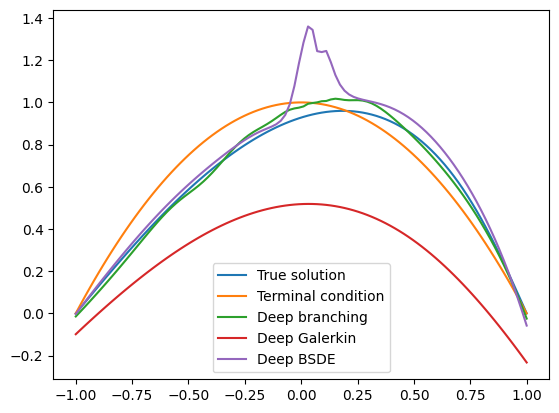

In [11]:
dim = 6
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,  
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 7

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 237.54307889938354 seconds.
Patch  0: epoch    0 with loss 5.64E-01


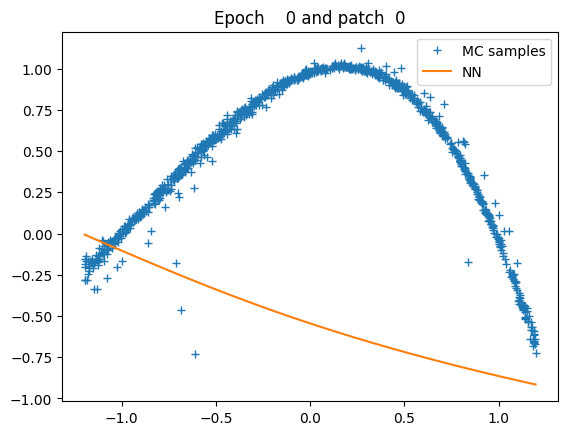

Patch  0: epoch  500 with loss 3.71E-03


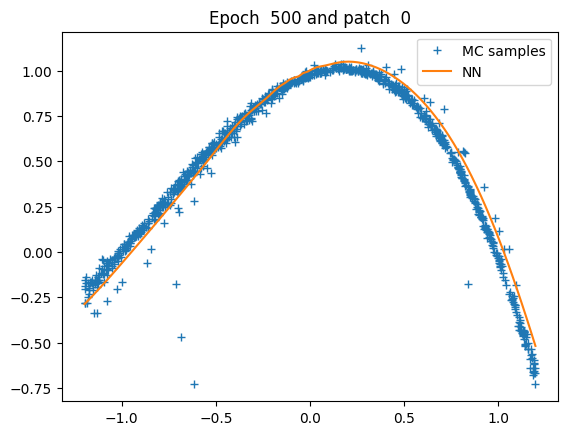

Patch  0: epoch 1000 with loss 3.90E-03


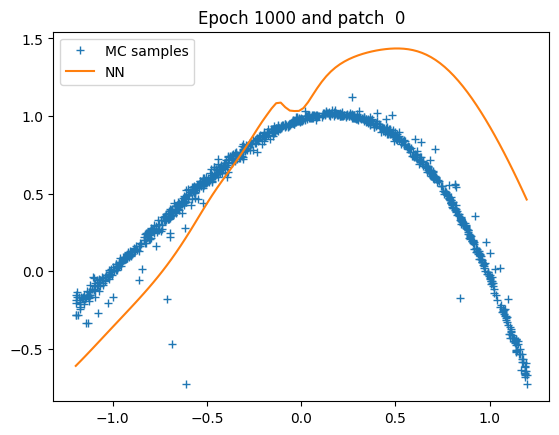

Patch  0: epoch 1500 with loss 3.69E-03


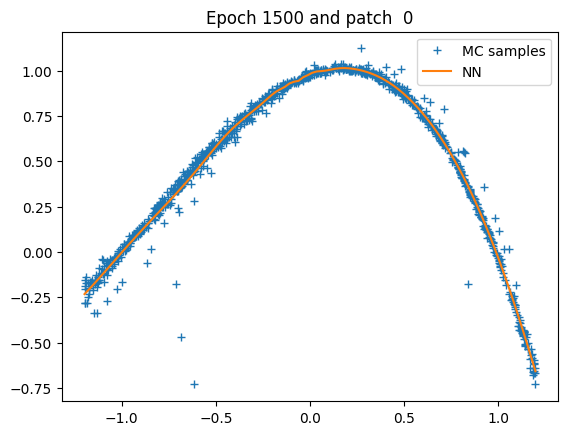

Patch  0: epoch 2000 with loss 3.69E-03


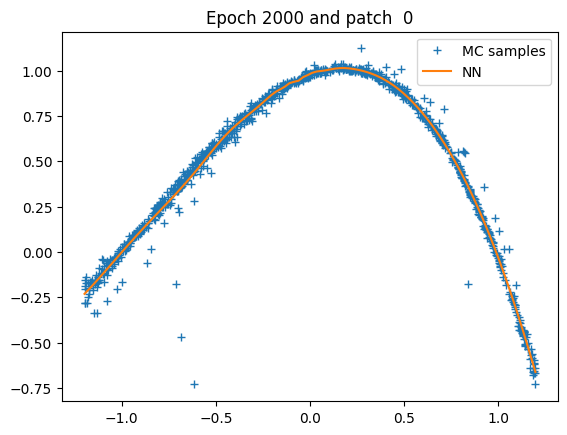

Patch  0: epoch 2499 with loss 3.69E-03


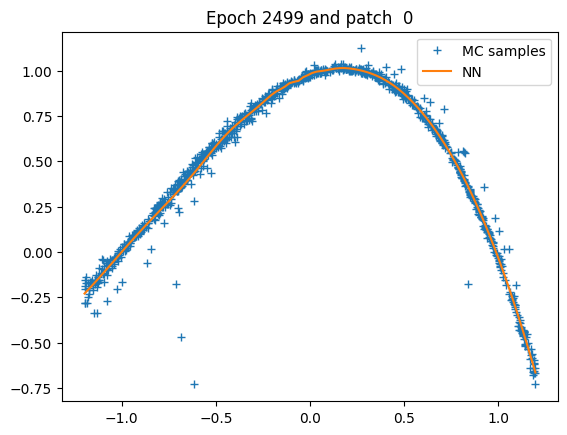

Patch 0: training of u with 2500 epochs take 17.391263961791992 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 176 seconds; L1 error: 2.72E-02; L2 error: 1.03E-03; rel error: INF.
fdb runtime: 80 seconds; total runtime: 256 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


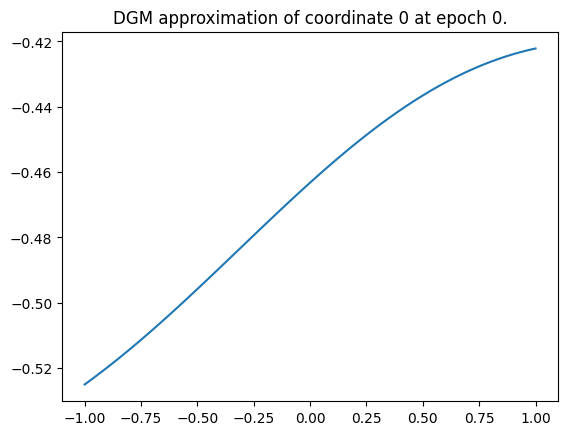

Epoch 0 with loss 12.64483642578125


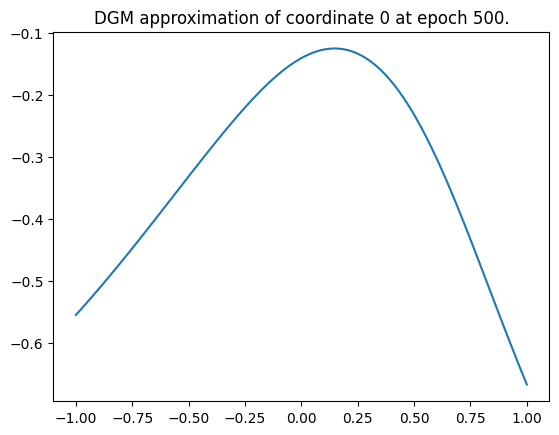

Epoch 500 with loss 9.176201820373535


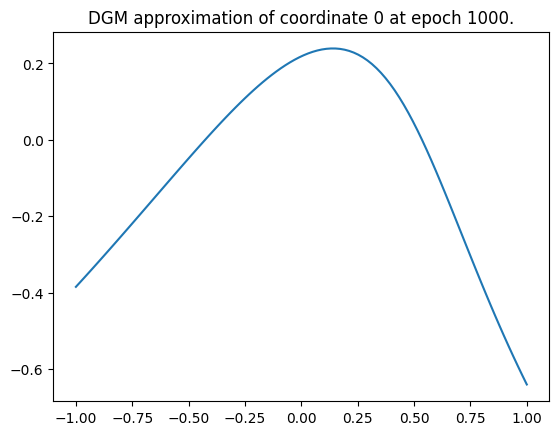

Epoch 1000 with loss 8.087109565734863


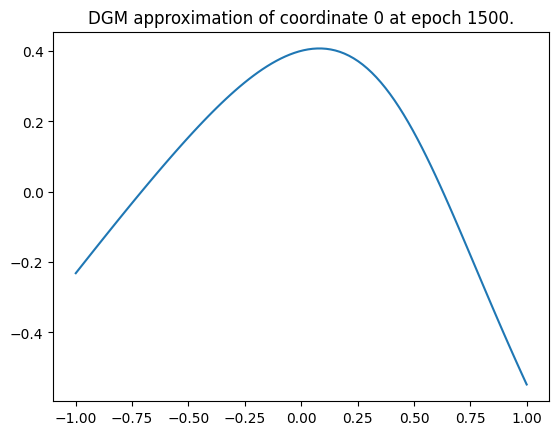

Epoch 1500 with loss 7.205900192260742


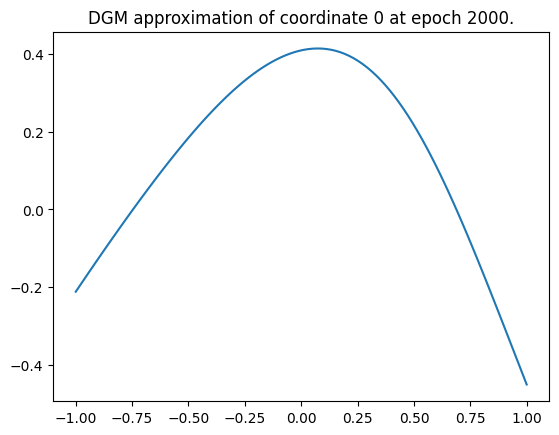

Epoch 2000 with loss 8.435694694519043


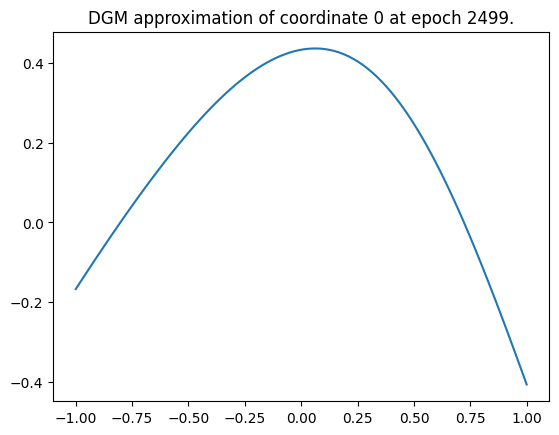

Epoch 2499 with loss 6.93892765045166
Training of neural network with 2500 epochs take 374.0361204147339 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 374 seconds; L1 error: 4.48E-01; L2 error: 2.16E-01; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


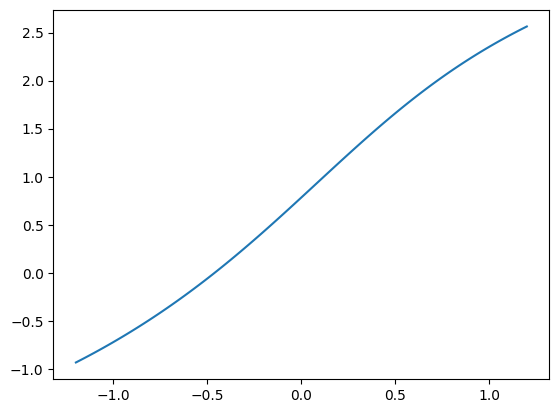

Epoch 0 with loss 0.680026650428772


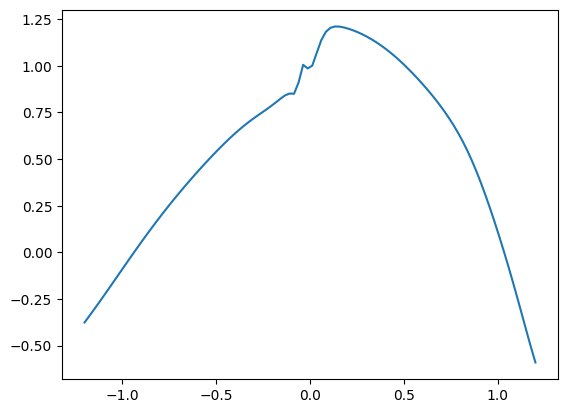

Epoch 500 with loss 0.003609349252656102


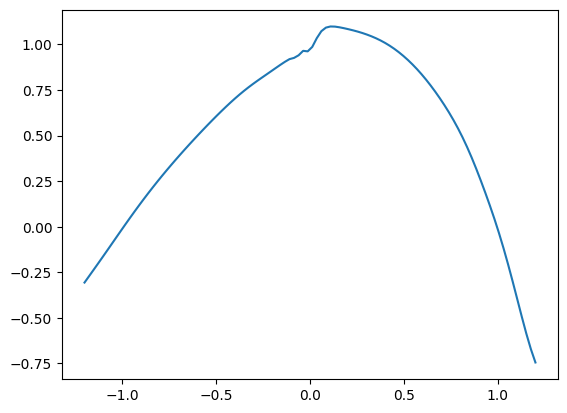

Epoch 1000 with loss 0.0029522329568862915


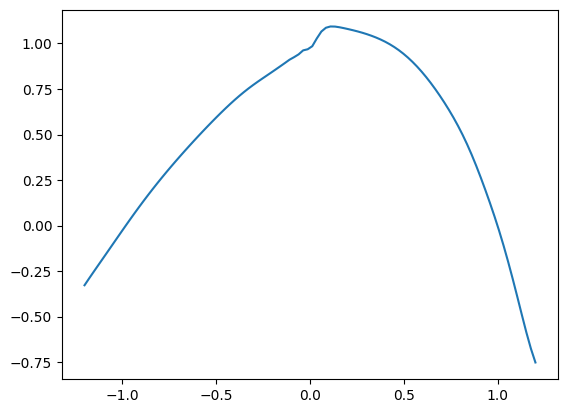

Epoch 1500 with loss 0.0005058956448920071


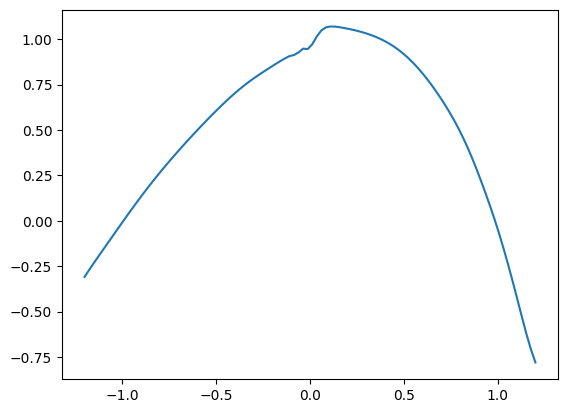

Epoch 2000 with loss 0.001746694091707468


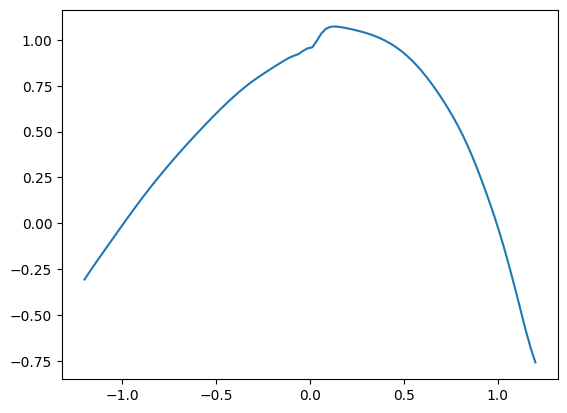

Epoch 2499 with loss 0.0006436065887100995
Training of neural network with 2500 epochs take 142.3057827949524 seconds.
Time taken: 142 seconds; L1 error: 4.30E-02; L2 error: 3.19E-03; rel error: INF.




######## Summary for deep branching method
runtime:        176
fdb runtime:    80
total runtime:  256
mean L1 error:  2.72E-02
std L1 error:   0.00E+00
mean L2 error:  1.03E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        374
mean L1 error:  4.48E-01
std L1 error:   0.00E+00
mean L2 error:  2.16E-01
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        142
mean L1 error:  4.30E-02
std L1 error:   0.00E+00
mean L2 error:  3.19E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


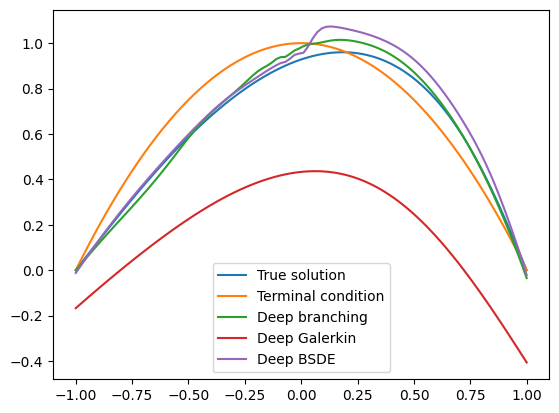

In [12]:
dim = 7
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 8

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 244.1167402267456 seconds.
Patch  0: epoch    0 with loss 2.70E+00


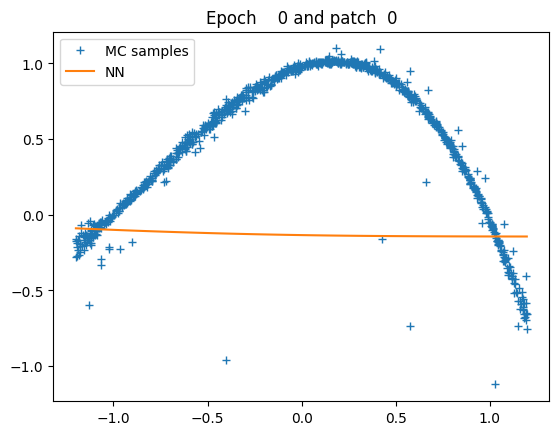

Patch  0: epoch  500 with loss 8.79E-03


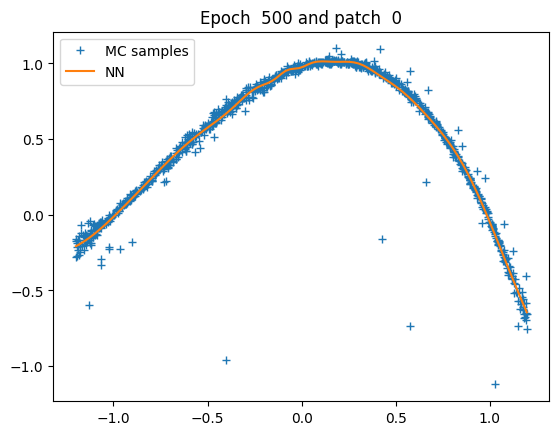

Patch  0: epoch 1000 with loss 8.78E-03


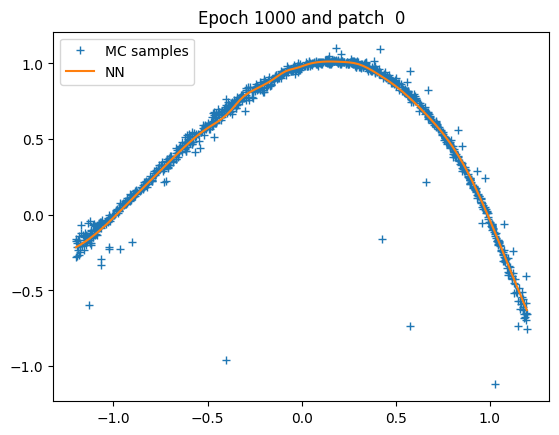

Patch  0: epoch 1500 with loss 8.77E-03


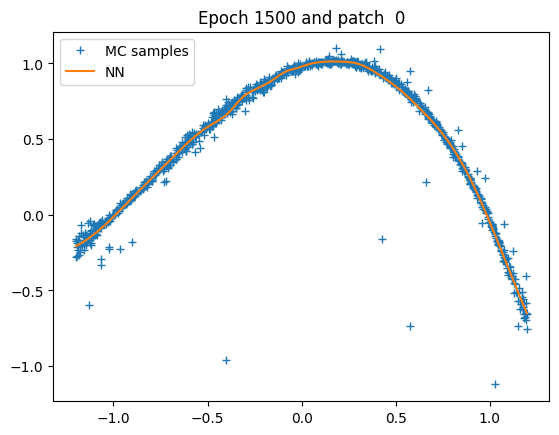

Patch  0: epoch 2000 with loss 8.77E-03


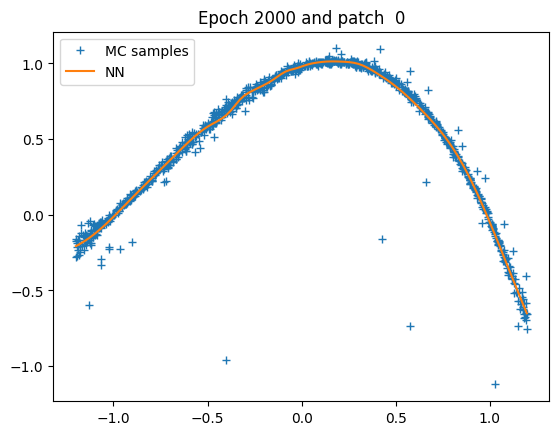

Patch  0: epoch 2499 with loss 8.77E-03


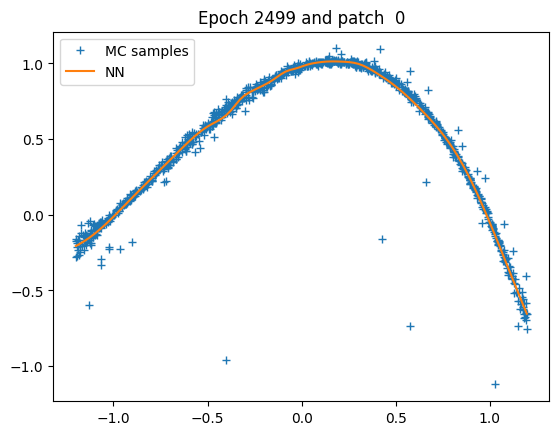

Patch 0: training of u with 2500 epochs take 17.345155477523804 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 197 seconds; L1 error: 2.34E-02; L2 error: 9.08E-04; rel error: INF.
fdb runtime: 66 seconds; total runtime: 264 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


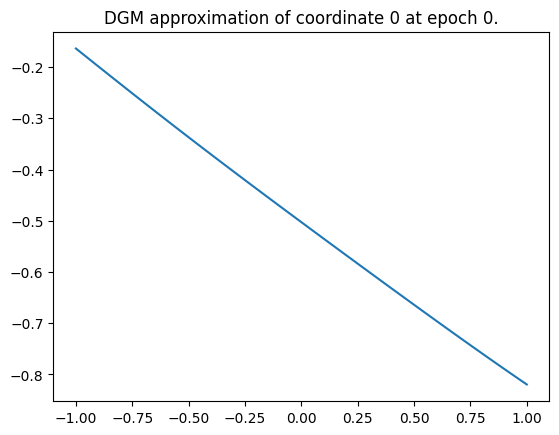

Epoch 0 with loss 16.276369094848633


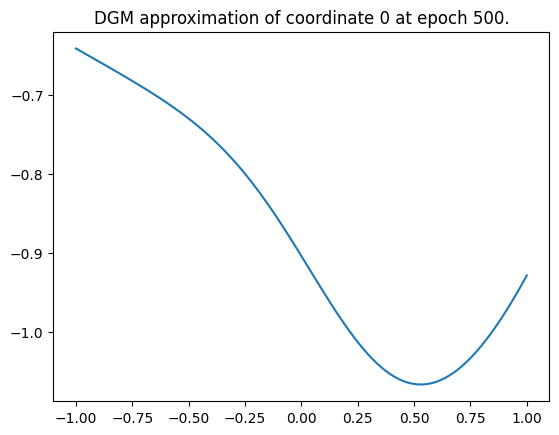

Epoch 500 with loss 13.004816055297852


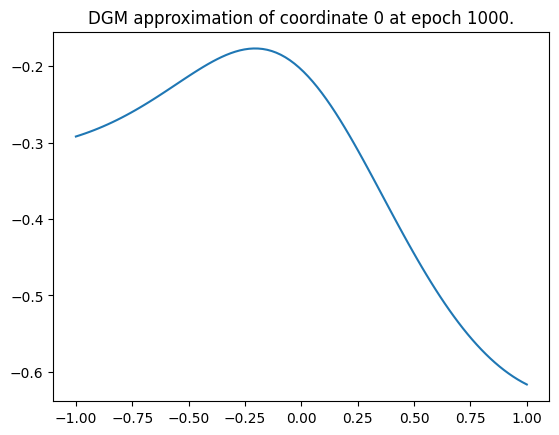

Epoch 1000 with loss 10.584487915039062


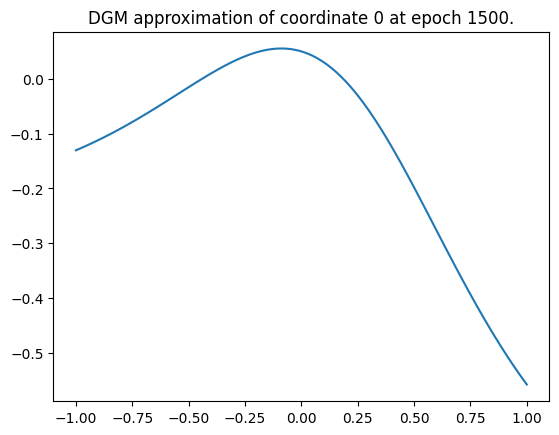

Epoch 1500 with loss 9.570823669433594


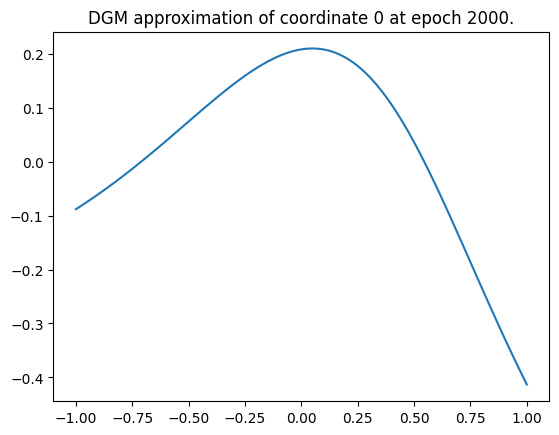

Epoch 2000 with loss 9.370326042175293


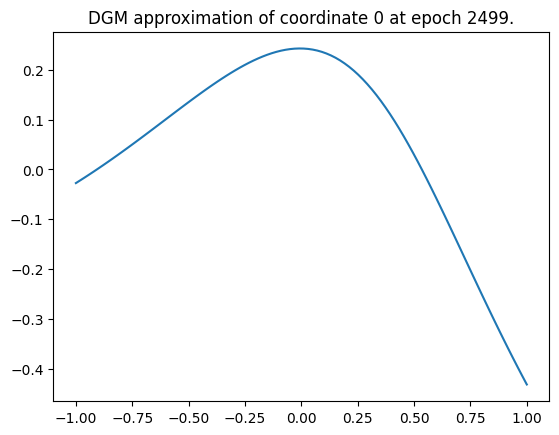

Epoch 2499 with loss 8.931771278381348
Training of neural network with 2500 epochs take 413.20255613327026 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 413 seconds; L1 error: 5.70E-01; L2 error: 3.73E-01; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


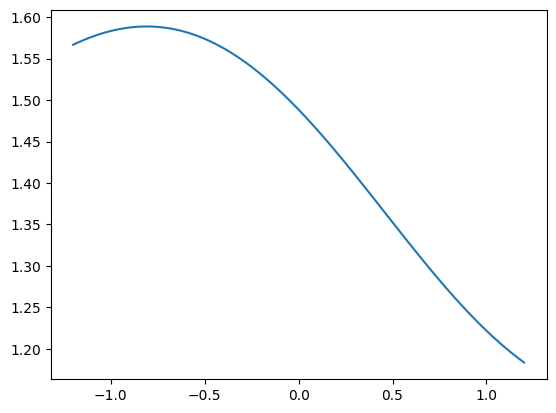

Epoch 0 with loss 1.3508689403533936


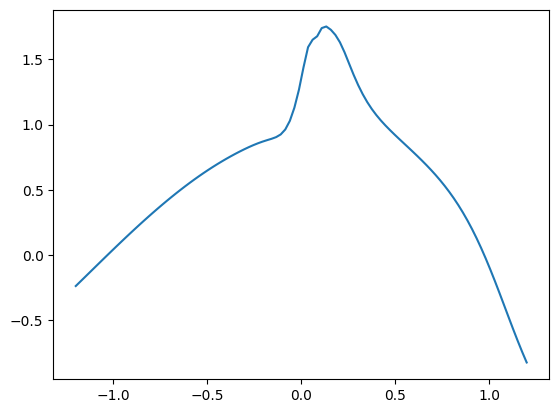

Epoch 500 with loss 0.0030149000231176615


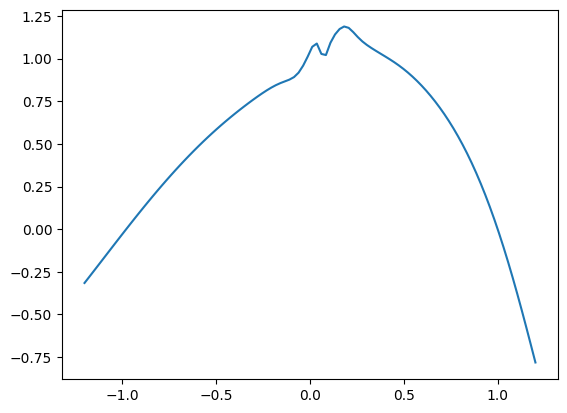

Epoch 1000 with loss 0.0006926291389390826


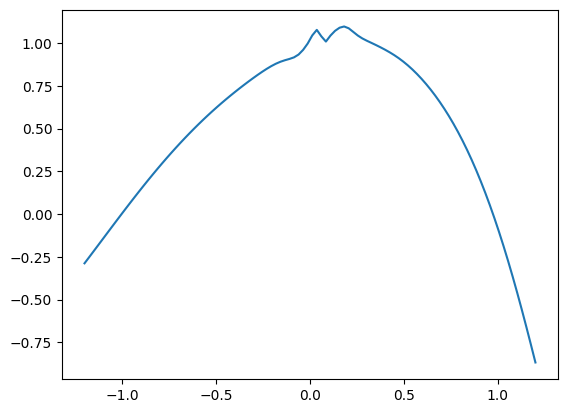

Epoch 1500 with loss 0.0022371122613549232


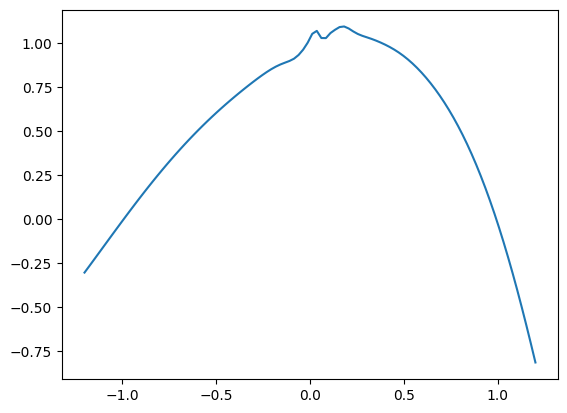

Epoch 2000 with loss 0.0013571567833423615


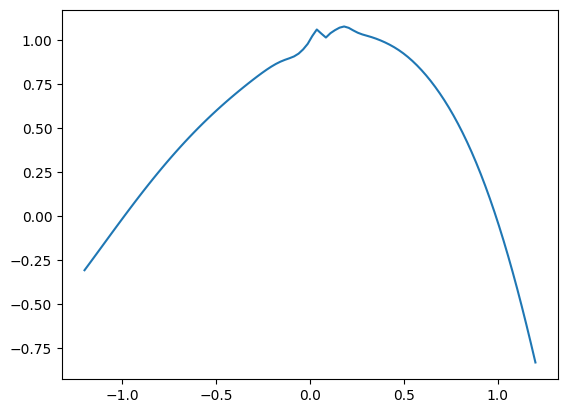

Epoch 2499 with loss 0.0013276370009407401
Training of neural network with 2500 epochs take 141.6294708251953 seconds.
Time taken: 142 seconds; L1 error: 4.18E-02; L2 error: 2.95E-03; rel error: INF.




######## Summary for deep branching method
runtime:        197
fdb runtime:    66
total runtime:  264
mean L1 error:  2.34E-02
std L1 error:   0.00E+00
mean L2 error:  9.08E-04
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        413
mean L1 error:  5.70E-01
std L1 error:   0.00E+00
mean L2 error:  3.73E-01
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        142
mean L1 error:  4.18E-02
std L1 error:   0.00E+00
mean L2 error:  2.95E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


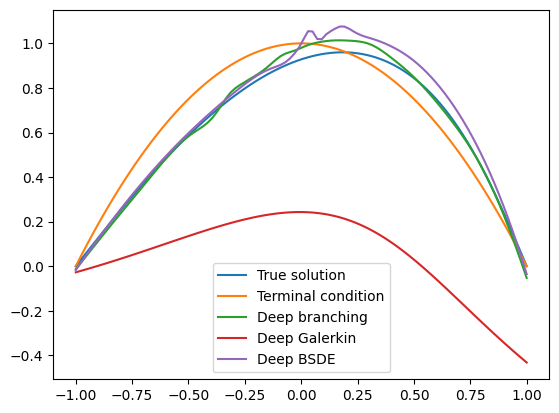

In [13]:
dim = 8
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,  
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 9

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 459.32785820961 seconds.
Patch  0: epoch    0 with loss 1.42E+00


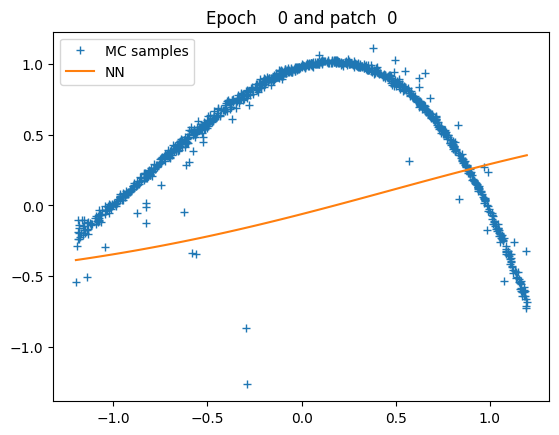

Patch  0: epoch  500 with loss 1.02E-02


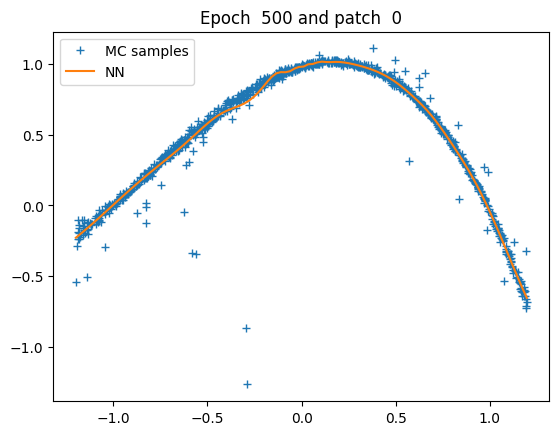

Patch  0: epoch 1000 with loss 1.02E-02


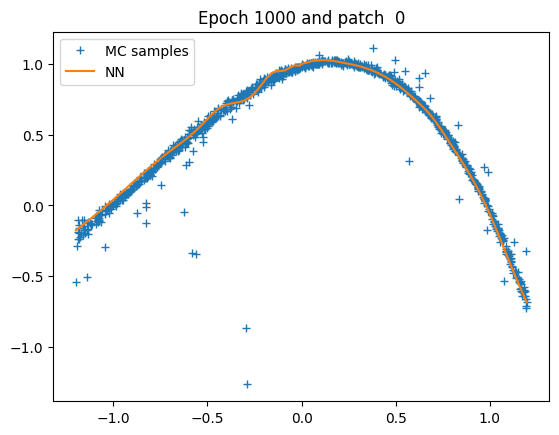

Patch  0: epoch 1500 with loss 1.01E-02


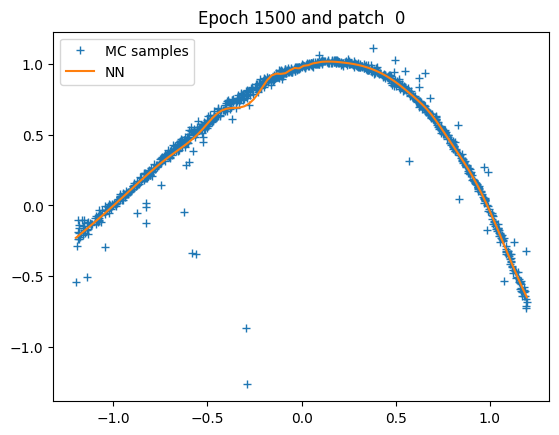

Patch  0: epoch 2000 with loss 1.00E-02


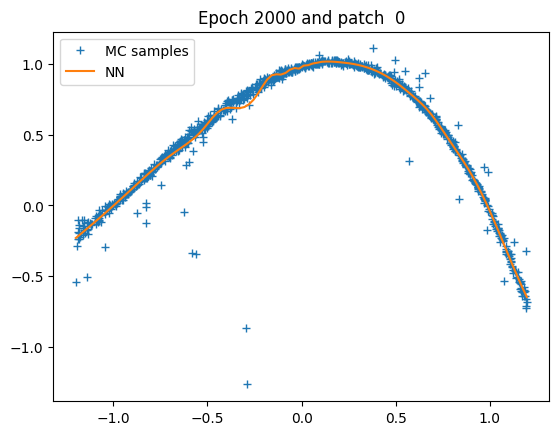

Patch  0: epoch 2499 with loss 1.00E-02


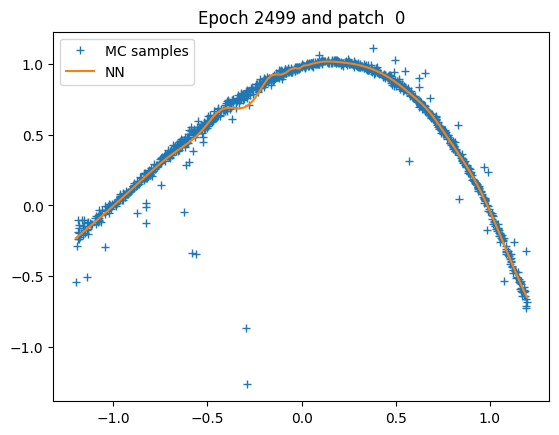

Patch 0: training of u with 2500 epochs take 17.235486268997192 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 260 seconds; L1 error: 2.97E-02; L2 error: 1.22E-03; rel error: INF.
fdb runtime: 220 seconds; total runtime: 480 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


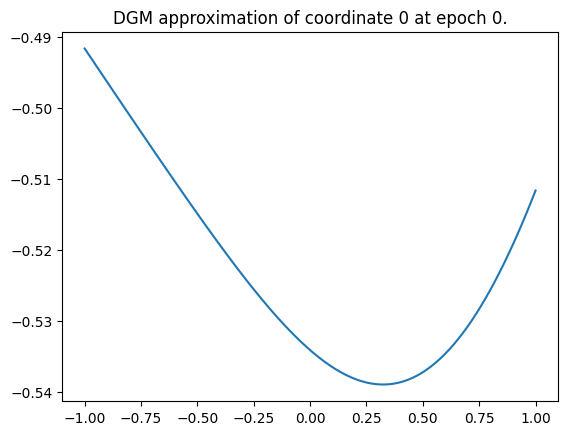

Epoch 0 with loss 18.563194274902344


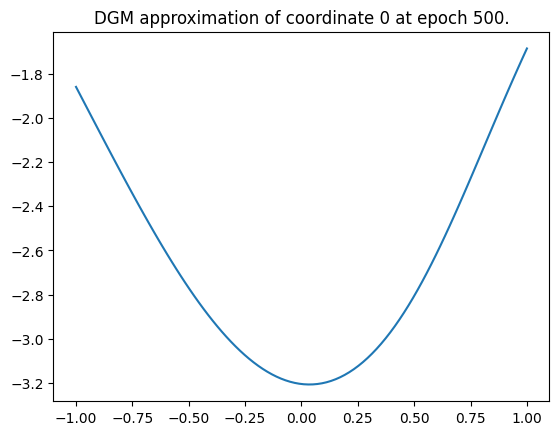

Epoch 500 with loss 16.91484832763672


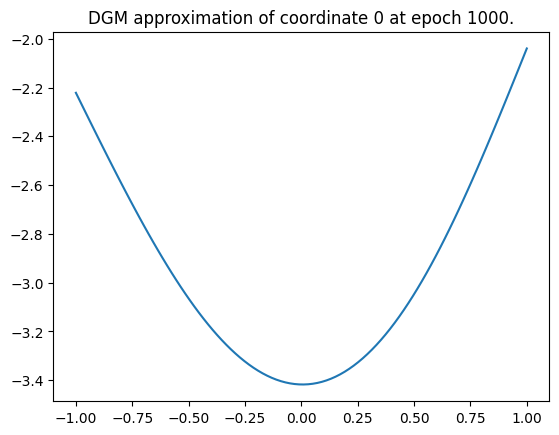

Epoch 1000 with loss 16.696762084960938


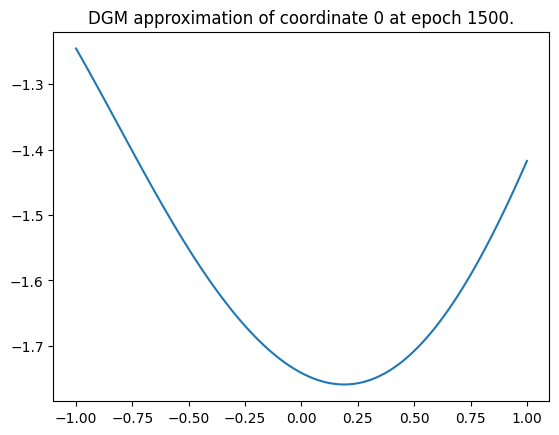

Epoch 1500 with loss 14.364115715026855


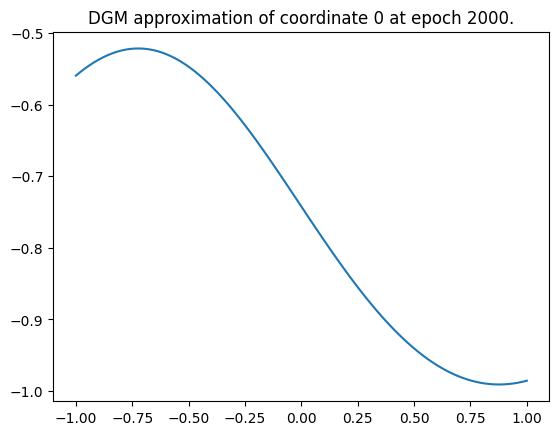

Epoch 2000 with loss 13.936519622802734


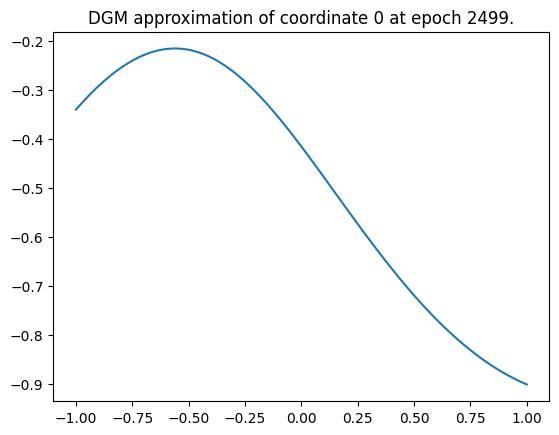

Epoch 2499 with loss 12.595674514770508
Training of neural network with 2500 epochs take 483.63413286209106 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 484 seconds; L1 error: 1.11E+00; L2 error: 1.38E+00; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


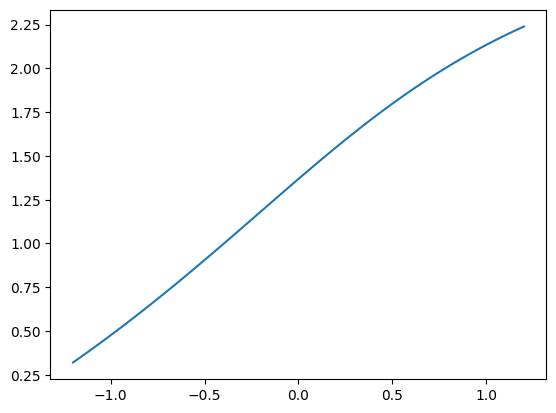

Epoch 0 with loss 1.5395841598510742


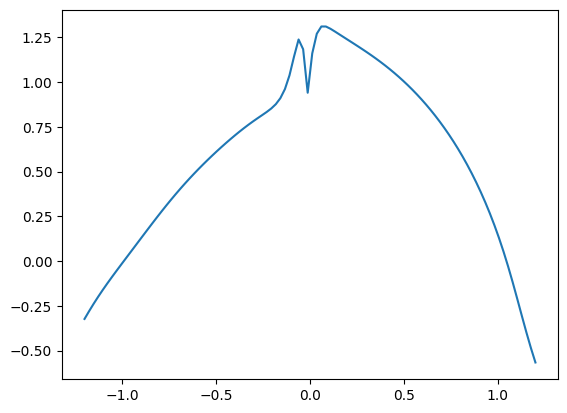

Epoch 500 with loss 0.00982110109180212


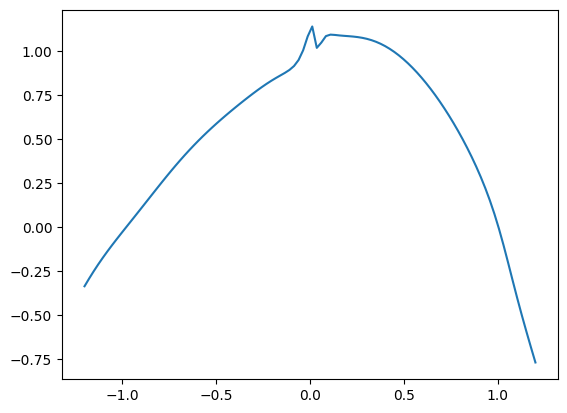

Epoch 1000 with loss 0.0017742012860253453


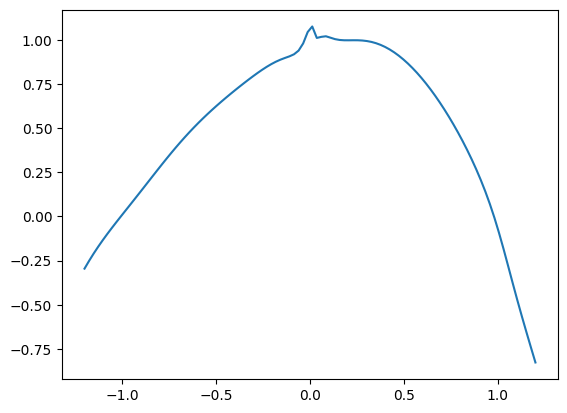

Epoch 1500 with loss 0.0008102567517198622


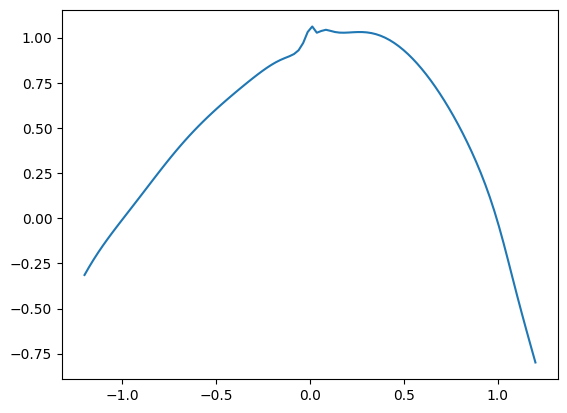

Epoch 2000 with loss 0.001747476402670145


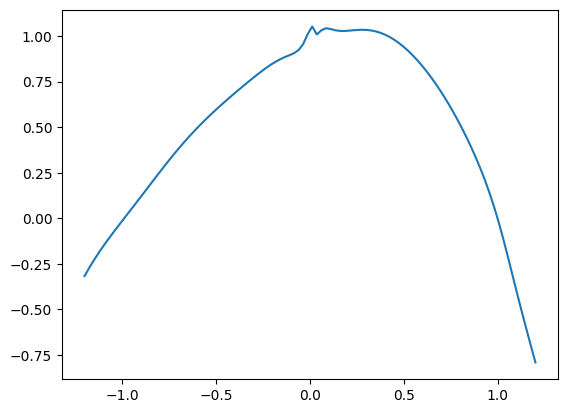

Epoch 2499 with loss 0.0007613940397277474
Training of neural network with 2500 epochs take 150.25370931625366 seconds.
Time taken: 150 seconds; L1 error: 4.46E-02; L2 error: 3.30E-03; rel error: INF.




######## Summary for deep branching method
runtime:        260
fdb runtime:    220
total runtime:  480
mean L1 error:  2.97E-02
std L1 error:   0.00E+00
mean L2 error:  1.22E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        484
mean L1 error:  1.11E+00
std L1 error:   0.00E+00
mean L2 error:  1.38E+00
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        150
mean L1 error:  4.46E-02
std L1 error:   0.00E+00
mean L2 error:  3.30E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


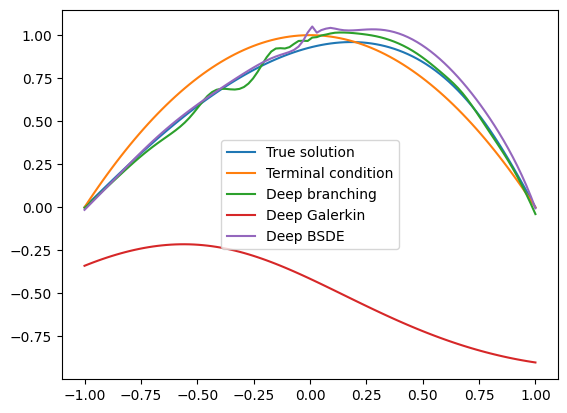

In [14]:
dim = 9
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True,  
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)

## dim = 10

#### Starting deep branching method with seed 0 - 1 out of 1 times


Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Generating batch 1/4
Generating batch 2/4
Generating batch 3/4
Generating batch 4/4


Patch 0: generation of u samples take 289.4929995536804 seconds.
Patch  0: epoch    0 with loss 9.20E-01


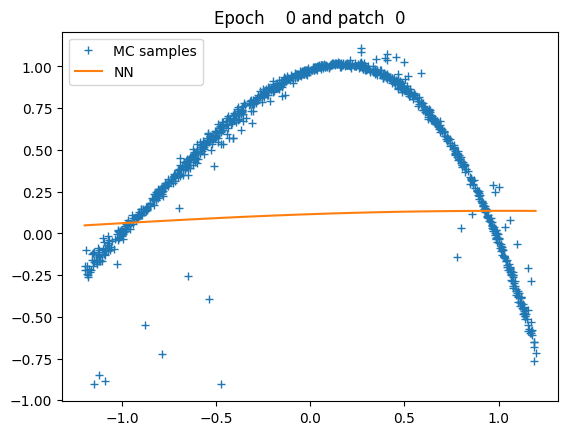

Patch  0: epoch  500 with loss 8.49E-03


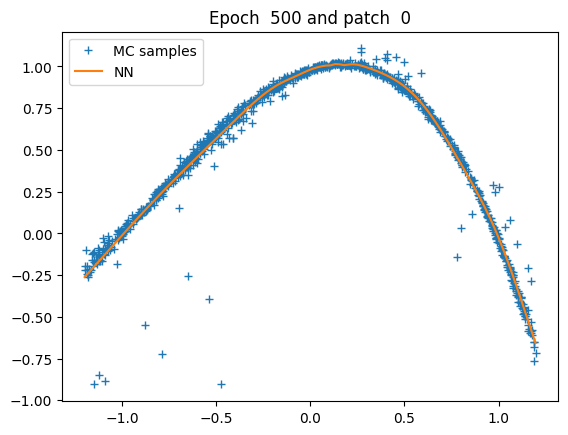

Patch  0: epoch 1000 with loss 8.49E-03


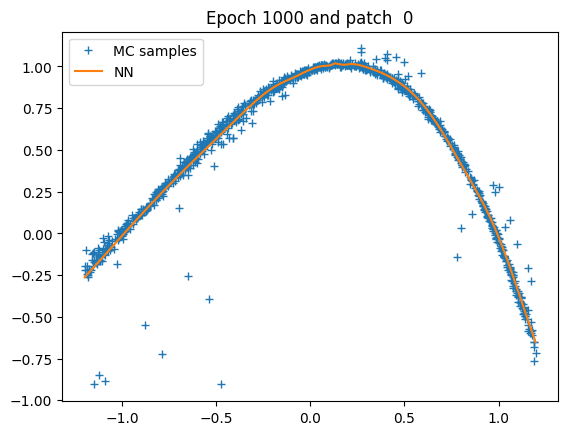

Patch  0: epoch 1500 with loss 8.49E-03


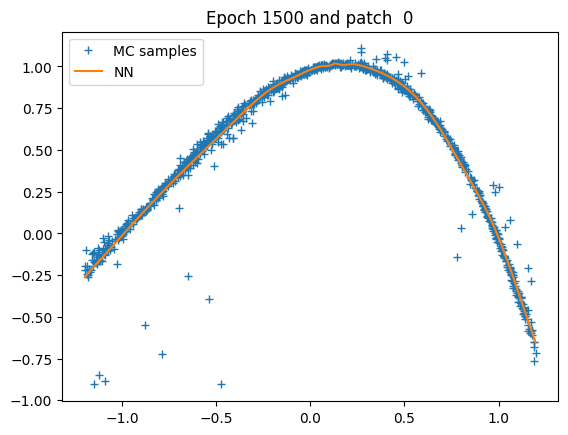

Patch  0: epoch 2000 with loss 8.49E-03


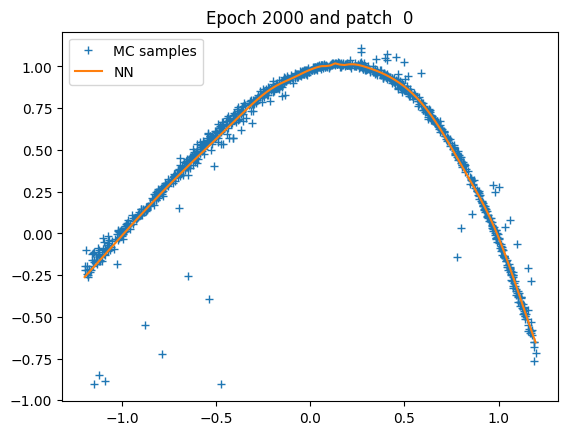

Patch  0: epoch 2499 with loss 8.49E-03


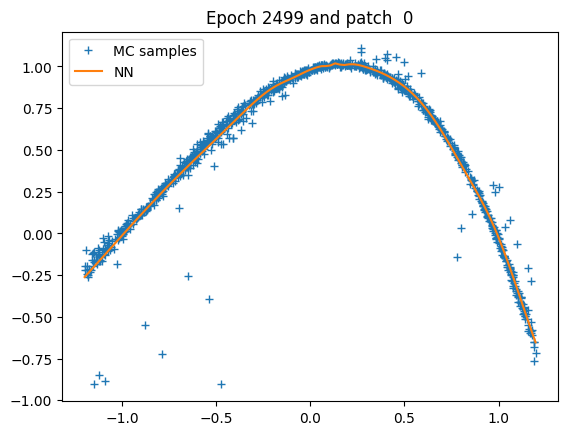

Patch 0: training of u with 2500 epochs take 18.15301823616028 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:76: RuntimeWarning: divide by zero encountered in divide
  branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
Logs are saved in D:\Work\URECA\deep-learning-pde-solvers-evaluation\logs\tmp


Time taken: 142 seconds; L1 error: 3.01E-02; L2 error: 1.13E-03; rel error: INF.
fdb runtime: 171 seconds; total runtime: 313 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 1 times


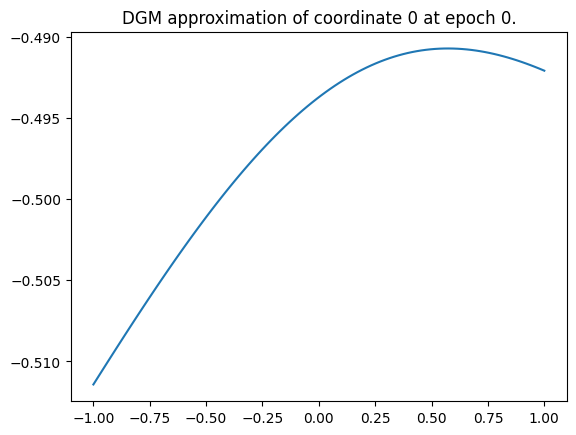

Epoch 0 with loss 28.197025299072266


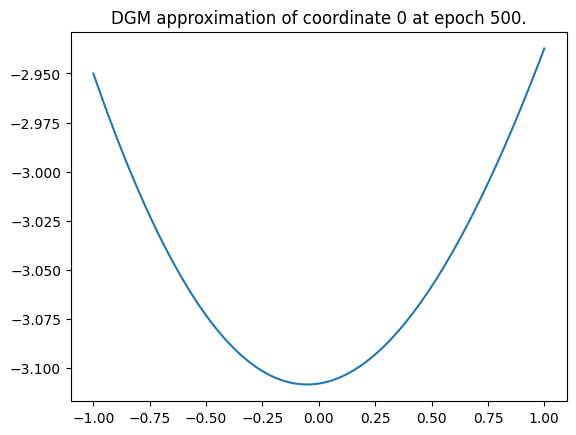

Epoch 500 with loss 20.5057315826416


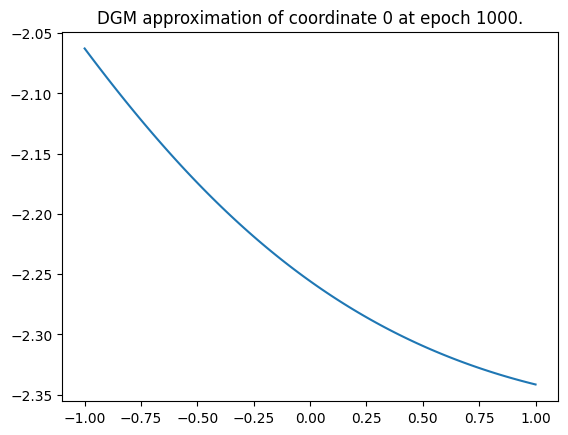

Epoch 1000 with loss 22.406227111816406


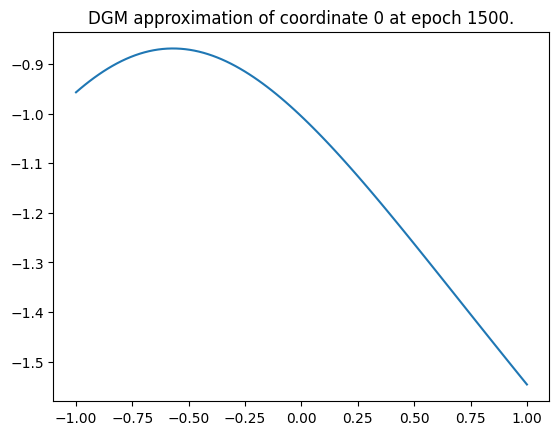

Epoch 1500 with loss 18.374170303344727


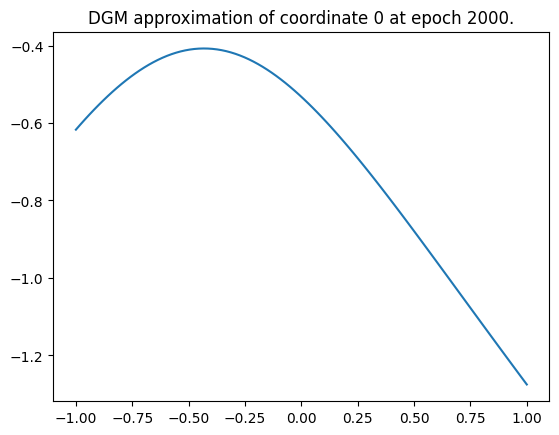

Epoch 2000 with loss 18.05552101135254


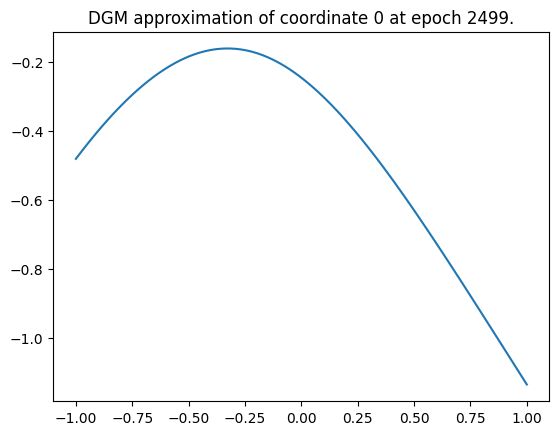

Epoch 2499 with loss 13.323099136352539
Training of neural network with 2500 epochs take 540.7955646514893 seconds.
D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:106: RuntimeWarning: divide by zero encountered in divide
  dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())


Time taken: 541 seconds; L1 error: 1.07E+00; L2 error: 1.26E+00; rel error: INF.
#### Starting deep BSDE method with seed 0 - 1 out of 1 times


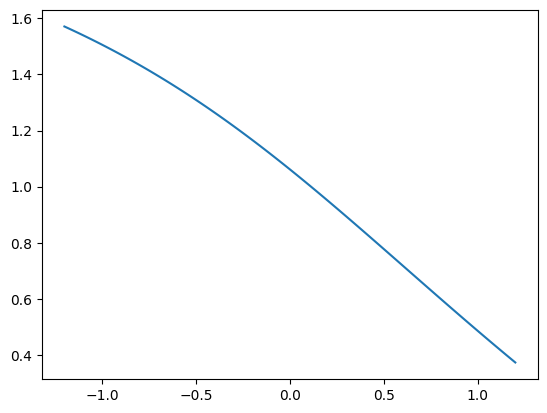

Epoch 0 with loss 1.8161358833312988


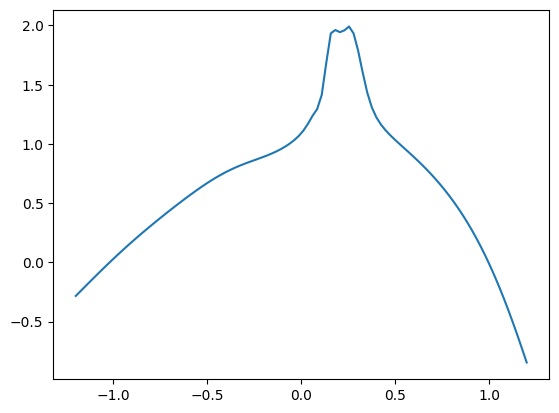

Epoch 500 with loss 0.003437005216255784


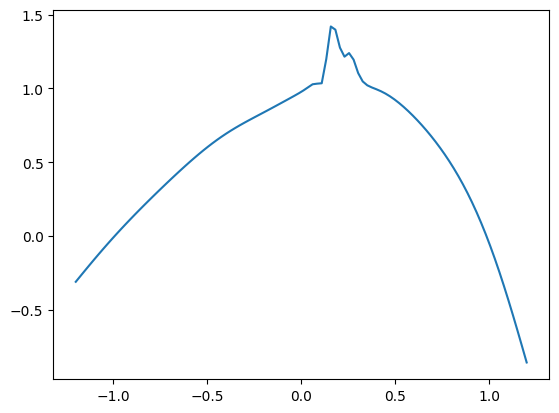

Epoch 1000 with loss 0.0009465973125770688


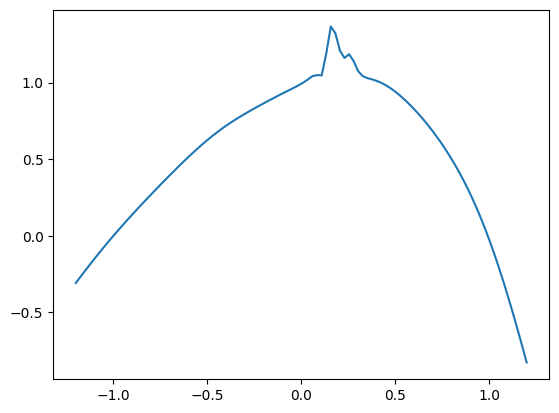

Epoch 1500 with loss 0.002507296623662114


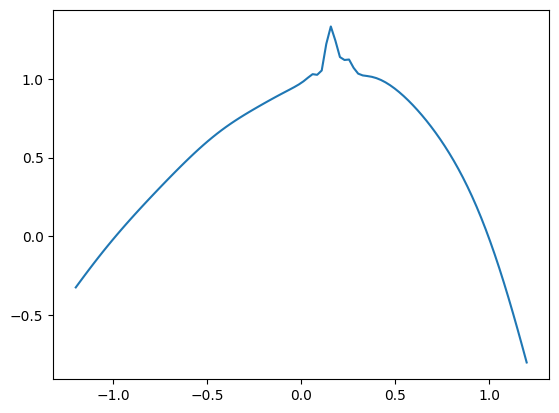

Epoch 2000 with loss 0.0010933229932561517


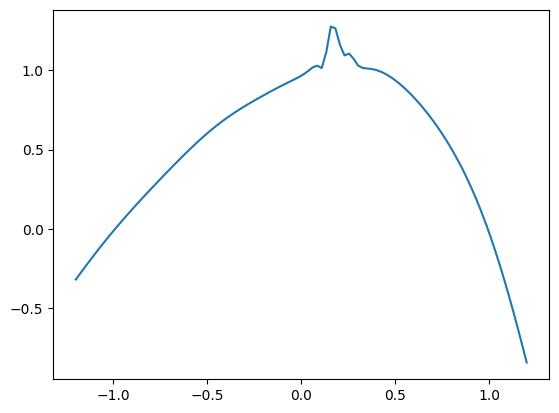

Epoch 2499 with loss 0.001160785905085504
Training of neural network with 2500 epochs take 152.78153371810913 seconds.
Time taken: 153 seconds; L1 error: 5.02E-02; L2 error: 5.96E-03; rel error: INF.




######## Summary for deep branching method
runtime:        142
fdb runtime:    171
total runtime:  313
mean L1 error:  3.01E-02
std L1 error:   0.00E+00
mean L2 error:  1.13E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep galerkin method
runtime:        541
mean L1 error:  1.07E+00
std L1 error:   0.00E+00
mean L2 error:  1.26E+00
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


######## Summary for deep BSDE method
runtime:        153
mean L1 error:  5.02E-02
std L1 error:   0.00E+00
mean L2 error:  5.96E-03
std L2 error:   0.00E+00
mean rel error: INF
std rel error:  NAN


D:\Work\URECA\deep-learning-pde-solvers-evaluation\notebooks\..\utilities\compare_performance.py:137: RuntimeWarning: divide by zero encountered in divide
  bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
C:\Users\fiat\anaconda3\envs\pdenn\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


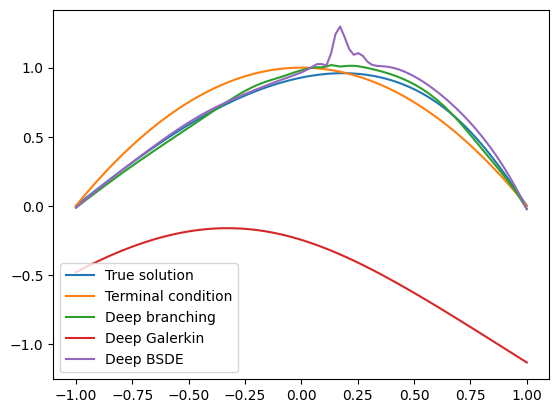

In [15]:
dim = 10
T=0.1/dim
grid_d_dim = np.concatenate((x_mid * np.ones((0, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)    
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)
deriv_map = np.concatenate((np.array([[0] * dim]), 1 * np.identity(dim), 2 * np.identity(dim)), axis=0).astype(int)

# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, seeds=[0],
                    # disable_branch=True,
                    # disable_bsde=True, 
                    # disable_galerkin=True, 
                    verbose=True, debug_mode=True, 
                    y_lo=x_lo, y_hi=x_hi, nu=nu,
                    T=T, device=device, epochs=2500, fname="test_case_2",
                    branch_nb_states=1000, branch_nb_path_per_state=1000,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=250,
                    second_order=True, bsde_nb_states=1000, bsde_nb_time_intervals=4,
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=deriv_map, phi_fun=phi_example,
                    boundary_fun=boundary_fun, dgm_overtrain_rate=0, outlier_percentile=5,
                    lr_gamma=0.1, branch_lr=1e-2, branch_activation="tanh", neurons=20, layers=8,
                    save_for_best_model=False, save_as_tmp=True)